<font size="+8"><center>
    Notebook for cell cycle data
</center></font>
<font size="+2"><center>
    Meichen Fang, Gennady Gorin, and Lior Pachter
</center></font>

# Preparation and exploratory data analysis
## Load packages

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS, PoissonMixture, GammaPoissonMixture
from Chronocell.plotting import *

2023.09.01


In [3]:
from scipy.special import softmax
from scipy.stats import spearmanr, pearsonr, entropy
import scanpy as sc
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cmr
from tqdm import tqdm
import pickle
from multiprocessing import Pool

In [4]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True

label_font = '30'
legend_font = '24'
title_font = '36'

color_palette = ["#d1e2e5","#a2c5ca","#458b94","#2a606b","#0e3442"]
cmap_teal = colors.LinearSegmentedColormap.from_list("Teals", color_palette, N=7)

In [5]:
import numpy.ma as ma

def plot_cor(A,B,ccc=False):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    fig, ax = plt.subplots(figsize=(6.4,4.8))
    #ax.loglog(A[msk],A[msk],'#6d7f9f',zorder=0,linewidth=12)
    if ccc:
        ax.scatter(A[msk],B[msk], color='#e07a5f',label="CCC="+str(np.round(CCC(X,Y),2))+"\n n="+str(np.sum(msk)));
    else:
        ax.scatter(A[msk],B[msk], color='#dca36a',label="Spearman's r="+str(np.round(pearsonr(X,Y).statistic,2))+"\n n="+str(np.sum(msk)));
    plt.legend(fontsize=24)

## Download data

!wget -O ./data/rpe1.h5ad https://www.dropbox.com/s/25enev458c8egn7/rpe1.h5ad?dl=1

In [7]:
with open('results/RPE1.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    data = pickle.load(f)

PM = data['PM']
traj_ws = data['ws']
trajs = data['ri']
traj = data['ri_tau']
X = traj.X.copy()
rd = traj.params['r']

TypeError: list indices must be integers or slices, not str

In [6]:
adata = sc.read('./data/rpe1_Pulse.h5ad')
adata

AnnData object with n_obs × n_vars = 2793 × 11502
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'sl_Size_Factor', 'initial_sl_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Gene_Id', 'beta', 'gamma', 'my_beta', 'my_gamma'
    uns: 'PCs', 'exp_type_colors', 'explained_variance_ratio_', 'feature_selection', 'pca_fit', 'pca_mean', 'pp', 'time_colors', 'velocyto_SVR'
    obsm: 'X', 'X_pca', 'X_spliced_pca', 'X_umap', 'cell_cycle_scores', 'velocity_umap'
    layers: 'M

In [7]:
adata.var.replace('None', np.nan, inplace=True)

In [8]:
# TimeLaspe-seq human K562
file_path = 'data/Schofield_ST2.xlsx'
Schofield = pd.read_excel(file_path,sheet_name='Table S2_K562')

# Calculate decay rate
Schofield['Decay Rate'] = np.log(2) / Schofield['mean_half_life']
Schofield = Schofield[~Schofield['Decay Rate'].isna()]

Schofield.head()

gene_name = adata.var_names.tolist()
Schofield_gamma = []
data_genes = np.array(Schofield['transcript'].tolist())
data_rates = np.array(Schofield['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Schofield_gamma.append(data_rates[idx])
    else:
        Schofield_gamma.append(np.nan)
        nan += 1
        
Schofield_gamma = np.array(Schofield_gamma)
nan 

6633

In [9]:
# Battich
file_path = 'data/Battich_RPE1_Gammas.csv'
Battich_data = pd.read_csv(file_path,header=1)
Battich_data

gene_Id   gene_name  degradation_rate_Battich_2020_RPE1
0     ENSG00000162772        ATF3                            0.126451
1     ENSG00000166845    C18orf54                            0.111220
2     ENSG00000210100       MT-TI                            0.657299
3     ENSG00000213965      NUDT19                            0.103158
4     ENSG00000149100       EIF3M                            0.059313
...               ...         ...                                 ...
6081  ENSG00000115993       TRAK2                            0.134040
6082  ENSG00000131171     SH3BGRL                            0.095601
6083  ENSG00000107518      ATRNL1                            0.580815
6084  ENSG00000155366        RHOC                            0.028213
6085  ENSG00000267374  AC016205.1                            0.416494

[6086 rows x 3 columns]

In [10]:
# Battich
file_path = 'data/Battich_RPE1_Gammas.csv'
Battich_data = pd.read_csv(file_path,header=1)

Battich_gamma = []
data_genes = np.array([gene.upper() for gene in Battich_data['gene_name'].astype(str).tolist()])
data_rates = np.array(Battich_data['degradation_rate_Battich_2020_RPE1'].astype(float).tolist())

gene_name = adata.var_names.tolist()
nan = 0 
for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Battich_gamma.append(data_rates[idx])
    else:
        Battich_gamma.append(np.nan)
        nan += 1
        
Battich_gamma = np.array(Battich_gamma)
nan 

5708

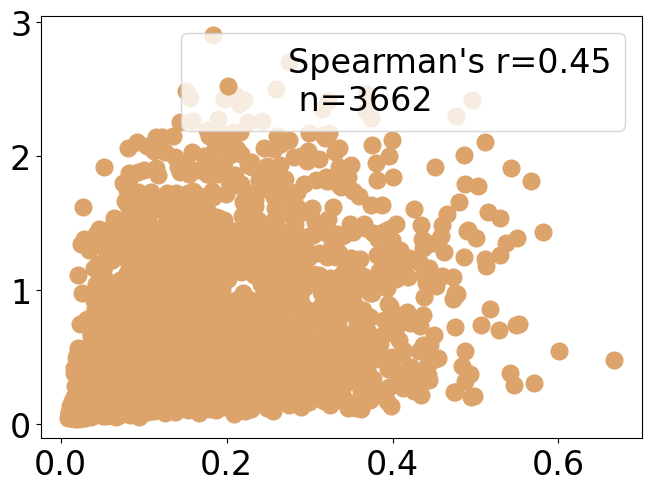

In [11]:
plot_cor(Battich_gamma,Schofield_gamma);

**Define marker genes and load gene length data**

In [12]:
marker_genes = ['UNG','PCNA','PLK1','MCM2','CDK1','CDK2','CDK3','CDK4','CDK5','CDK6']
#marker_genes = ['ENSG00000076248','ENSG00000132646','ENSG00000166851','ENSG00000073111','ENSG00000170312']
plot_marker_genes = adata.var_names[adata.var_names.isin(marker_genes)]
print(plot_marker_genes)

Index(['MCM2', 'UNG', 'CDK6', 'CDK2', 'PCNA', 'CDK4', 'CDK5', 'PLK1', 'CDK1'], dtype='object')


In [13]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
Lb_gene_length = np.array([int(gene[1]) for gene in gene_length_file])
Lb_gene_name = np.array([gene[0].upper() for gene in gene_length_file])
print(np.sum(adata.var_names.isin(Lb_gene_name)))

11012


**PCA plots and marker gene expresssion**

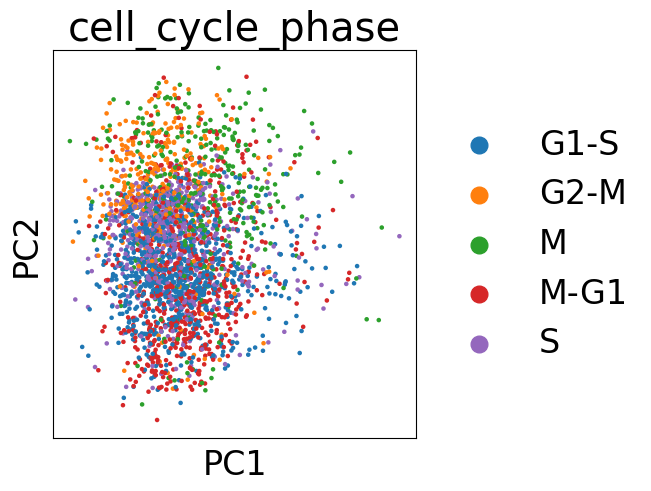

In [109]:
xx = np.zeros((adata.n_obs,2))
xx[:,1] = adata.obs['GFP_log10_corrected']
xx[:,0] = adata.obs['RFP_log10_corrected']

sc.pl.pca(adata,color=['cell_cycle_phase'])

**Define clusters and cell colors**

In [15]:
times = adata.obs.time
Times = (0.25,0.5,0.75,1,2,3)

stages = adata.obs.time
Stages = (0.25,0.5,0.75,1,2,3)

color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Stages))

In [16]:
clusters = adata.obs['cell_cycle_phase'].astype(str)
Clusters = ('M-G1','G1-S', 'S', 'G2-M', 'M')

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]

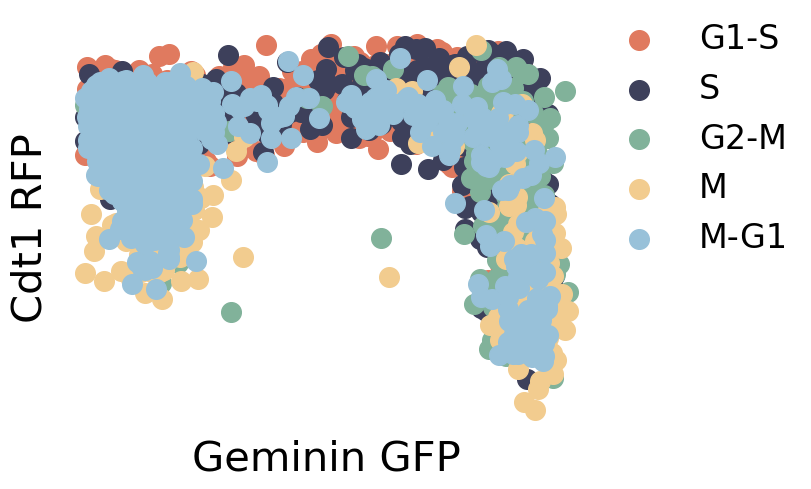

In [110]:
fig, ax = plt.subplots(1,1,figsize=(8,4.8))

ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    im=ax.scatter(xx[idx,0],xx[idx,1],color=cmap_cluster(i),label=Cluster,alpha=1,s=200);
ax.legend(loc=(1,0.4),fontsize=legend_font,frameon=False)
ax.set_xlabel(r'Geminin GFP',fontsize=label_font)
ax.set_ylabel(r'Cdt1 RFP',fontsize=label_font)

ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

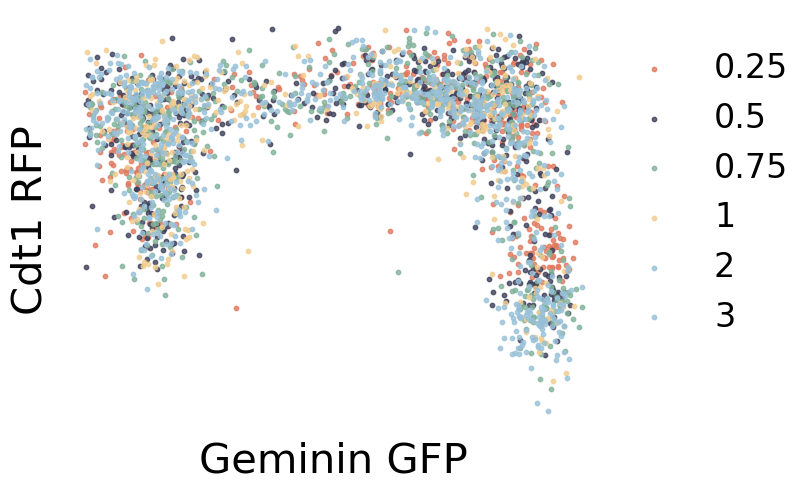

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,4.8))

ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
for i,Time in enumerate(Times):
    idx = times.isin([Time])
    im=ax.scatter(xx[idx,0],xx[idx,1],color=cmap_cluster(i),label=Time,alpha=0.8,s=10);
ax.legend(loc=(1,0.2),fontsize=legend_font,frameon=False)
ax.set_xlabel(r'Geminin GFP',fontsize=label_font)
ax.set_ylabel(r'Cdt1 RFP',fontsize=label_font)

ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

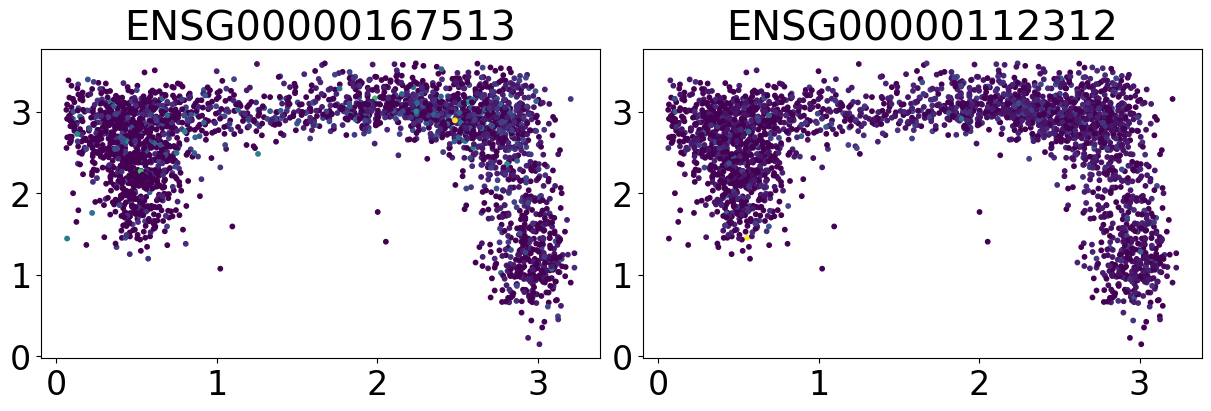

In [20]:
Genes = ['ENSG00000167513','ENSG00000112312']

fig, ax = plt.subplots(1,2,figsize=(12,4))
for i,gene in enumerate(Genes):
    ax[i].set_title(gene)
    ax[i].scatter(xx[:,0],xx[:,1],c=adata.layers['total'].toarray()[:,adata.var['Gene_Id'].isin([gene])]/adata.layers['total'].toarray().mean(axis=1,keepdims=True)*adata.layers['total'].toarray().mean(),s=10,cmap='viridis');

## Gene variance

0.17196769527714262 0.7905026931289771


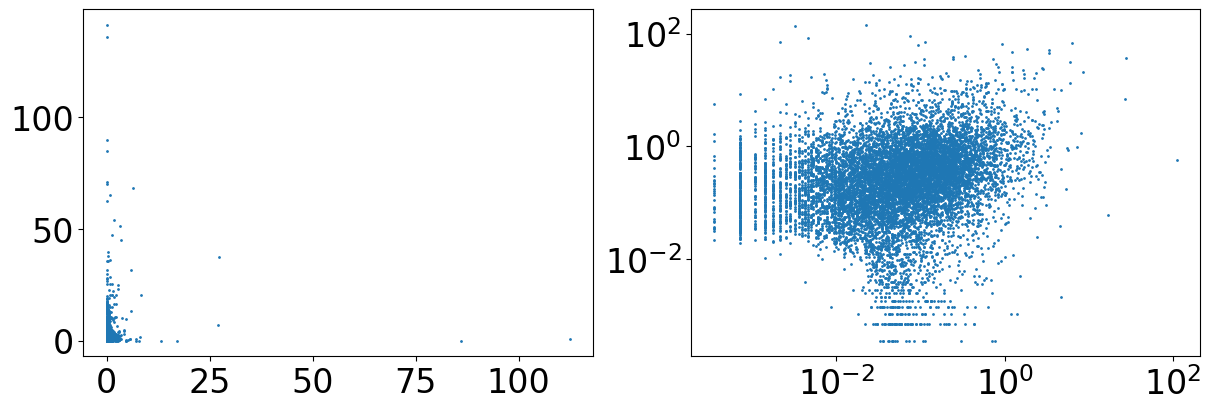

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [22]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) & (adata.layers["unspliced"].toarray().mean(0) > 0)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.17695937058444058
s estimated by normalized covariance of total S counts = 0.18033481660785494
s estimated by normalized covariance of total counts = 0.16512801360362928
s estimated by total counts = 0.16910295428083022


In [23]:
a=1
sp=s1

X_bar = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
for i in range(5):
    Pgene_mask = (X_mean > 0.01) & (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   
    P = (S + U)[:,Pgene_mask]
    n,p = P.shape
    P_cov = np.cov(P,rowvar=False)
    P_mean = np.mean(P,axis=0)
    P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
    sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
    print(Pgene_mask.mean(),"s:", str(sp))

0.5136341581756428 s: 0.16158710601103488
0.5045123726346433 s: 0.16144137007966652
0.5043182920912178 s: 0.1614333561690122
0.5041242115477923 s: 0.1614358490722503
0.5041242115477923 s: 0.1614358490722503


Text(0.02, 0.5, 'CV$^2$')

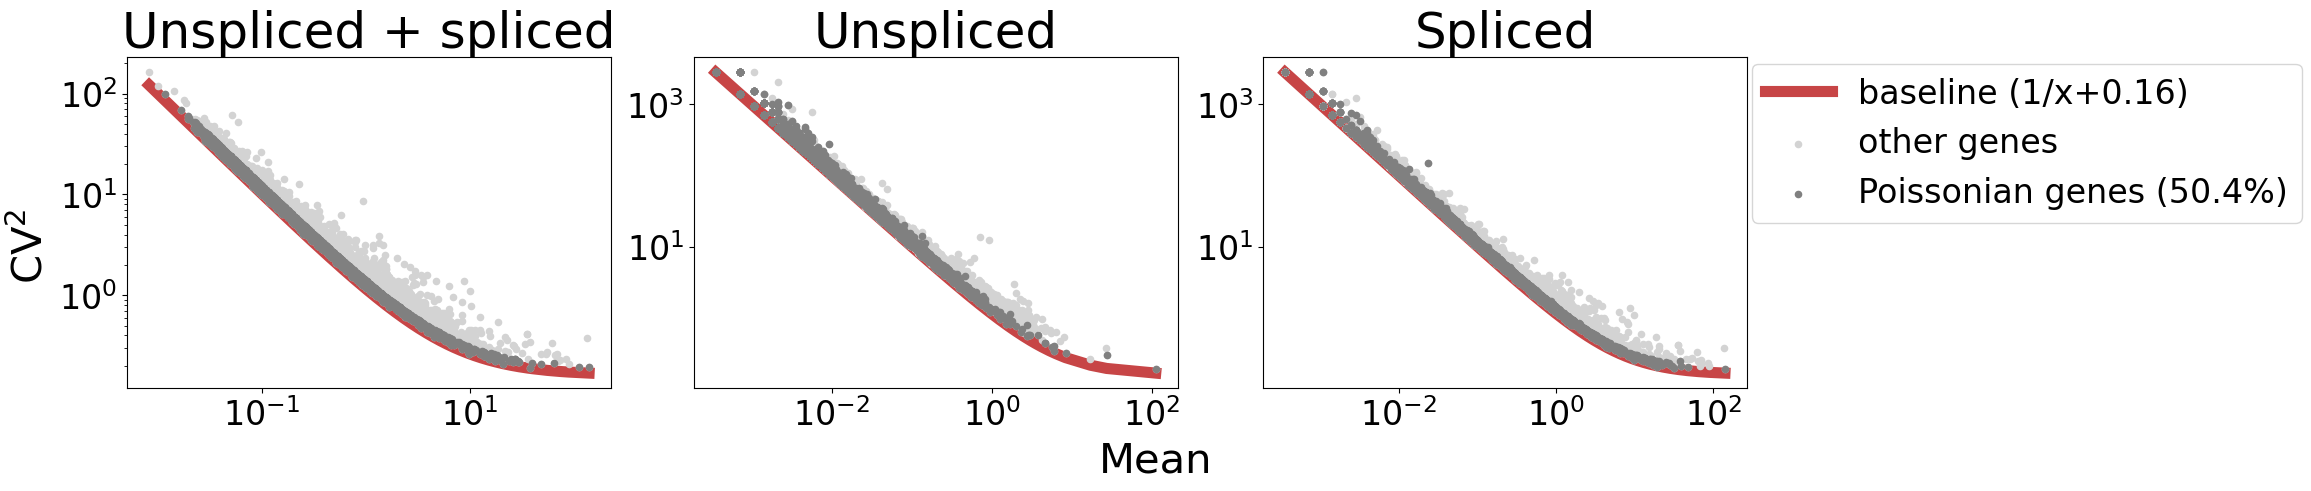

In [24]:
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

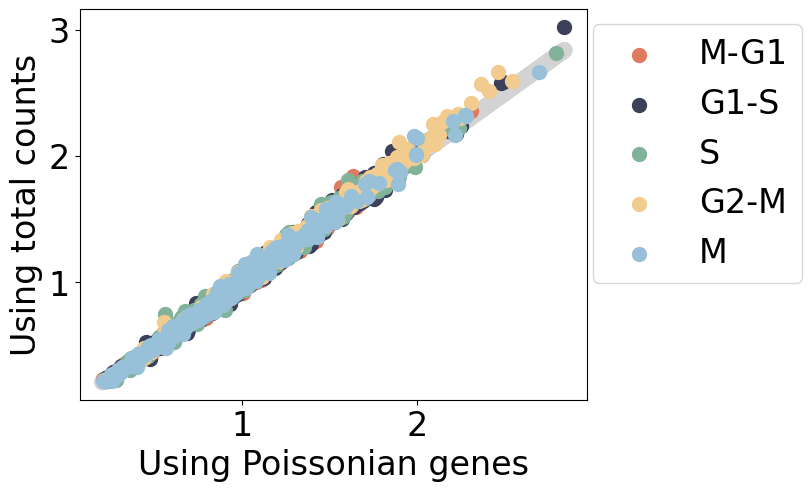

In [25]:
rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()
rd_ = X_total/X_total.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster(i),alpha=1,s=100,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0.3),fontsize=legend_font)

## Select genes

In [814]:
var_threshold = 1.5
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.5) \
    & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_3290703/1458620001.py:7: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3290703/1458620001.py:8: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3290703/1458620001.py:9: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_3290703/1458620001.py:9: RuntimeWarning:

divide by zero encountered in log



188

In [815]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
cell_cycle_genes = np.array([gene.upper() for gene in cell_cycle_genes])
#fitted_genes = fitted_genes[fitted_genes.isin(cell_cycle_genes)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(np.sum(fitted_genes.isin(cell_cycle_genes)))

24


182


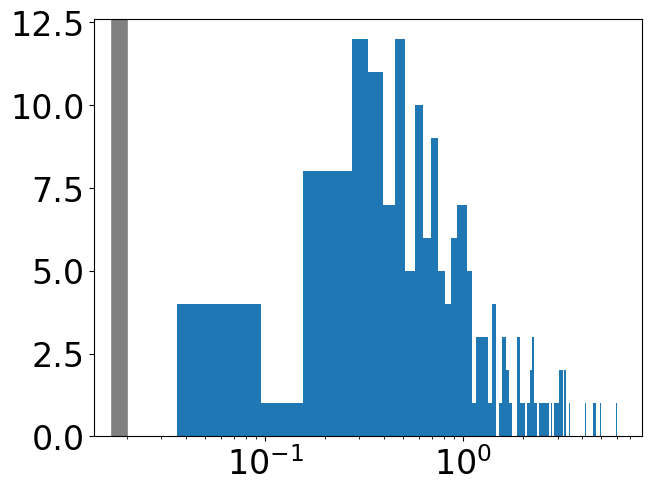

In [28]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

/tmp/ipykernel_3290703/3805144832.py:3: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3290703/3805144832.py:4: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_3290703/3805144832.py:11: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3290703/3805144832.py:12: RuntimeWarning:

divide by zero encountered in divide



Text(0.02, 0.5, 'Variance')

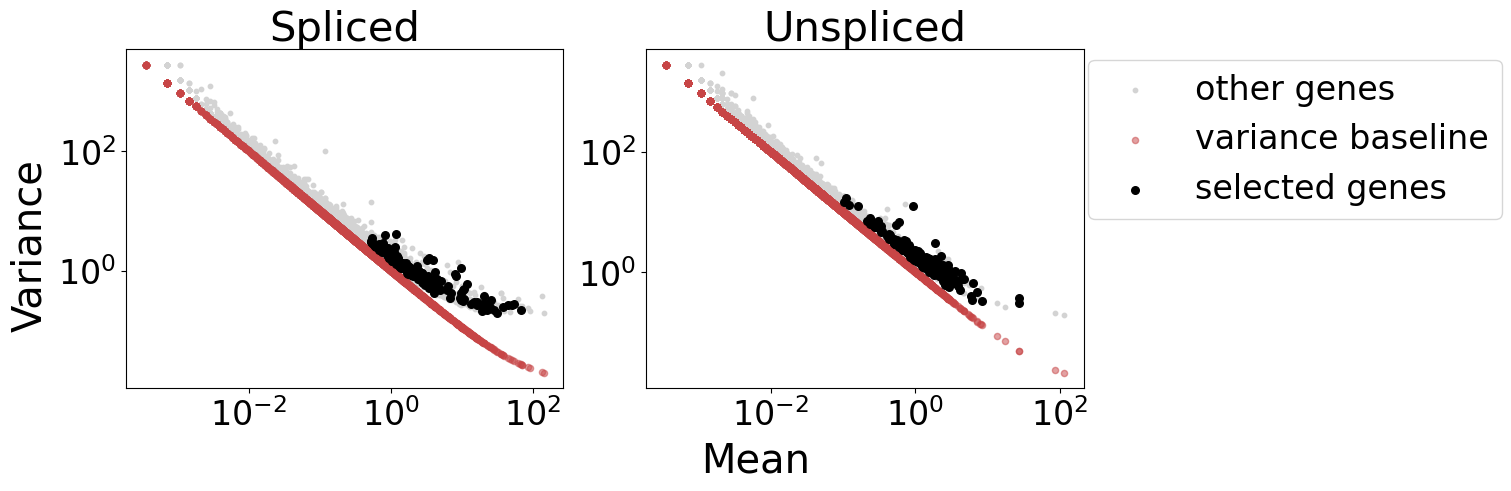

In [817]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=30, c='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=30, c='k', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

## Get X

1.7438295586991797 5.265660351486619


/tmp/ipykernel_3290703/4144493180.py:2: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_3290703/4144493180.py:3: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3290703/4144493180.py:7: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_3290703/4144493180.py:8: RuntimeWarning:

invalid value encountered in divide



(2793, 188, 2)

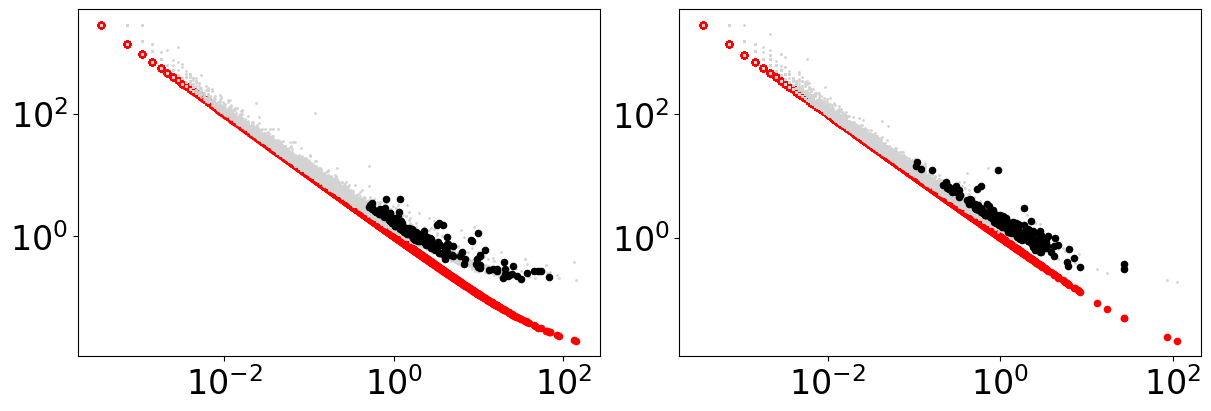

In [812]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + sp, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + sp, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X[:,:,0].mean(),X[:,:,1].mean())
X.shape

In [32]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
if plot_idx.sum() == 0:
    plot_idx = np.arange(10)
else:
    print(fitted_genes[plot_idx])

Index(['MCM2', 'CDK1', 'CDK6'], dtype='object')


0.6515444812974351 1.324427631087137


(2793, 182, 2)

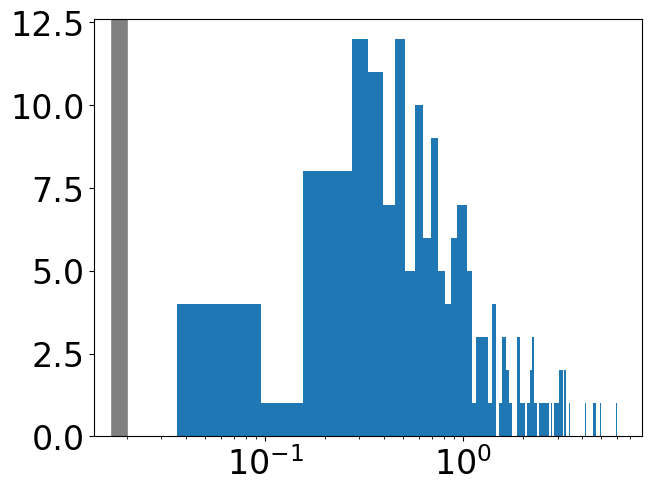

In [31]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
Lb_gene_name = np.array([gene[0] for gene in gene_length_file])

Ub_gene_idx = np.array([ np.where(Lb_gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes],dtype=int)
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X[:,:,0].mean(),X[:,:,1].mean())
X.shape

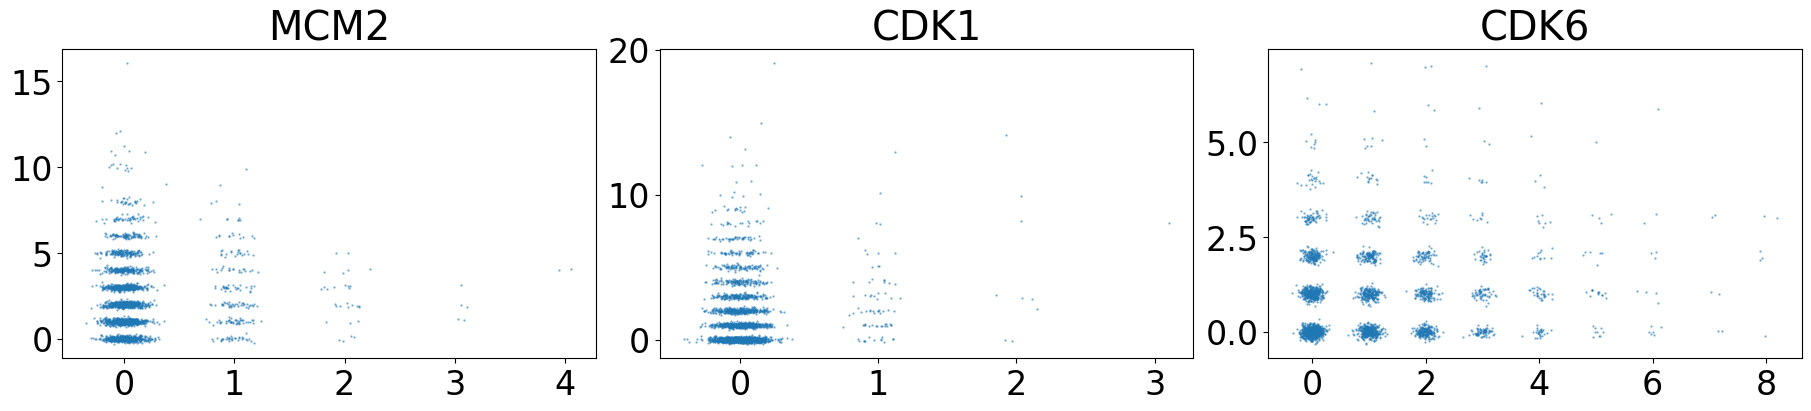

In [33]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
pp = len(plot_idx)

if len(plot_idx) == 0:
    pass
elif len(plot_idx) == 1:
    j = plot_idx
    plt.scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])
else:
    fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
    for i in range(len(plot_idx)):
        j = plot_idx[i]
        ax[i].set_title(fitted_genes[j])
        ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [34]:
xx = adata.obs['RFP_log10_corrected'].astype(float)
clusters = np.around(xx/xx.max()*2,0)

x = np.zeros((adata.n_obs,2))
x[:,1] = adata.obs['GFP_log10_corrected']
x[:,0] = adata.obs['RFP_log10_corrected']

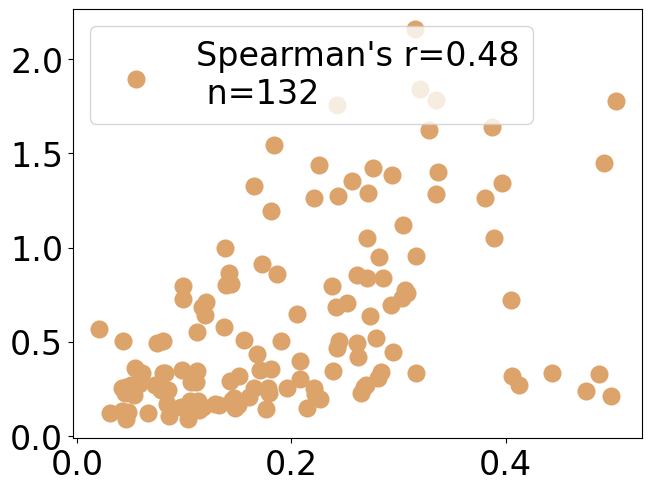

In [35]:
plot_cor(Battich_gamma[fitted_idx],Schofield_gamma[fitted_idx]);

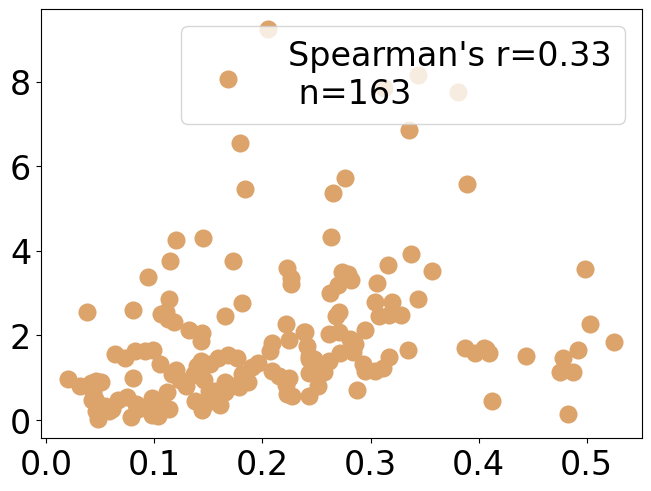

In [38]:
plot_cor(Battich_gamma[fitted_idx],1/X[:,:,1].mean(0));

## Mixtures fitting

1 -340.59961390756627 -340.7299397221026 -341.1166732076028
2 -333.8029414786881 -333.99878823844466 -334.57995092132546
3 -330.4052808507469 -330.66664855572367 -331.442240435985
4 -329.00863707804626 -329.33552572824317 -330.3055468058851
5 -327.9746615125291 -328.36707110794623 -329.5315213829688
6 -327.3242659152545 -327.78219645589184 -329.1410759282949


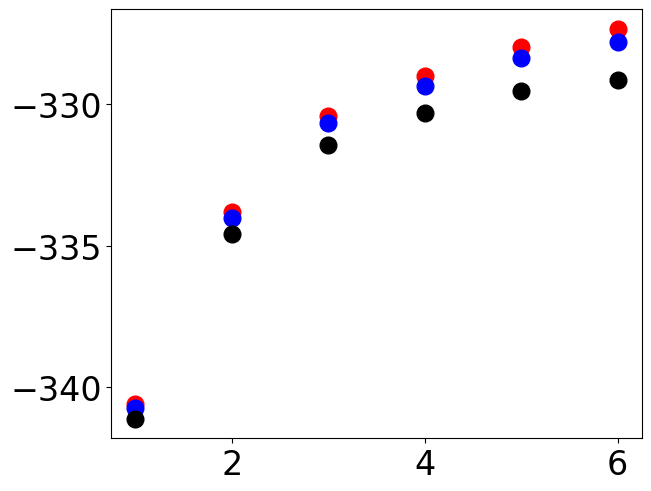

In [39]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixtureSS(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X),color='b')
    plt.scatter(nc,PM.compute_BIC(X),color='k')
    print(nc,PM.compute_lower_bound(X),PM.compute_AIC(X),PM.compute_BIC(X))

array([0.19737996, 0.32102429, 0.48159576])

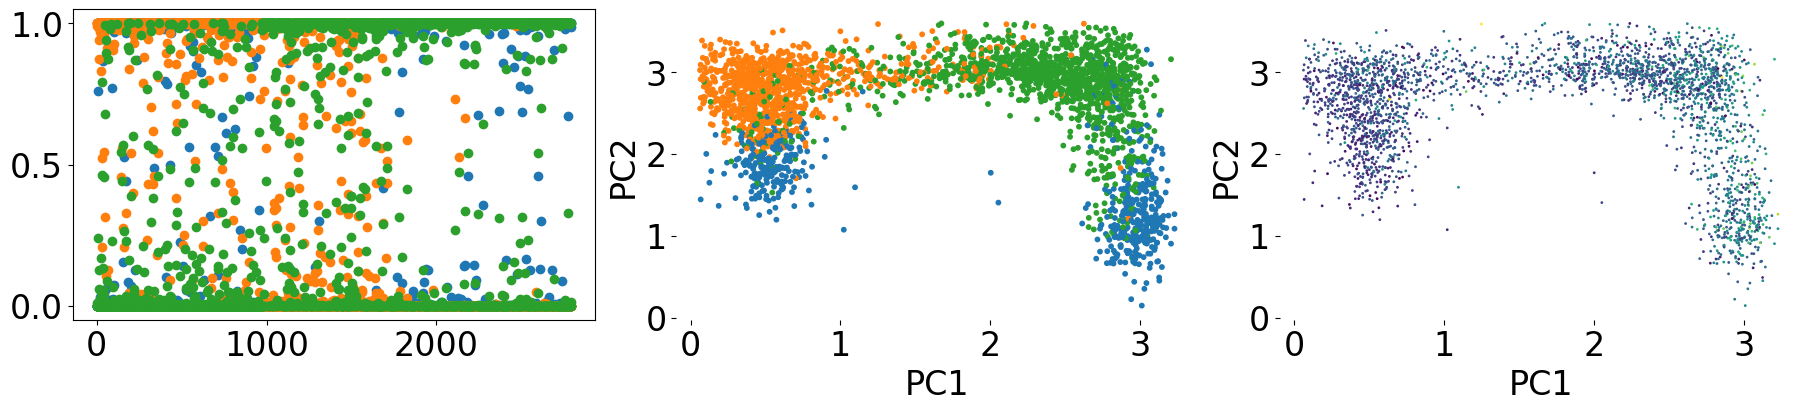

In [40]:
PM = PoissonMixtureSS(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=1)],s=10);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

ax[2].scatter(x[:,0],x[:,1],c=rd,s=1);
ax[2].set_xlabel('PC1',fontsize=24)
ax[2].set_ylabel('PC2',fontsize=24)
ax[2].set_frame_on(False)
PM.weights

In [41]:
PM.elbo = elbo

In [42]:
cluster_gene_logL, cluster_KL = PM.compute_gene_logL(X,Q)
cluster_KL 

-0.9842200274879215

In [43]:
data={'PM': PM}

# Trajectory fitting

In [739]:
topo = np.array([[0,1,2,0]])
tau = (0,1,2,3)
traj_params={"r":rd}

## Warm start

In [74]:
clusters = adata.obs['cell_cycle_phase'].astype(str)
Clusters = ('G1-S', 'S', 'G2-M', 'M', 'M-G1')

0.3258145363408521
0.20229144289294665
0.11886860007160759
0.13498030791263874
0.21804511278195488


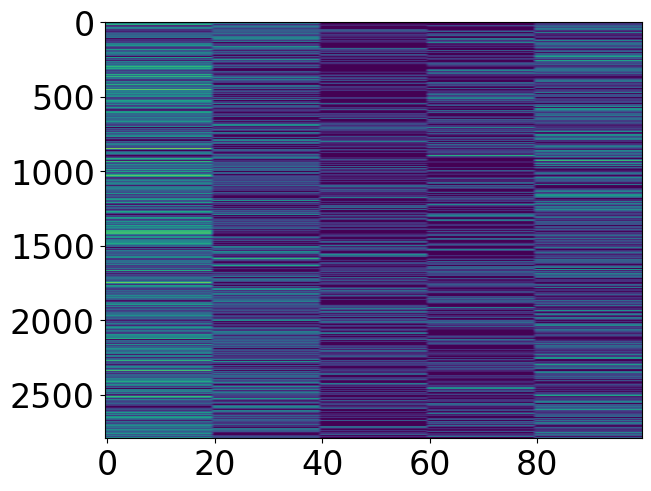

In [75]:
m=100
weight0 = np.zeros((adata.n_obs,1,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    print(idx.sum()/adata.n_obs)
    weight0[idx,:,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=(1,2),keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0
plt.imshow(Q0[:,0],aspect='auto')

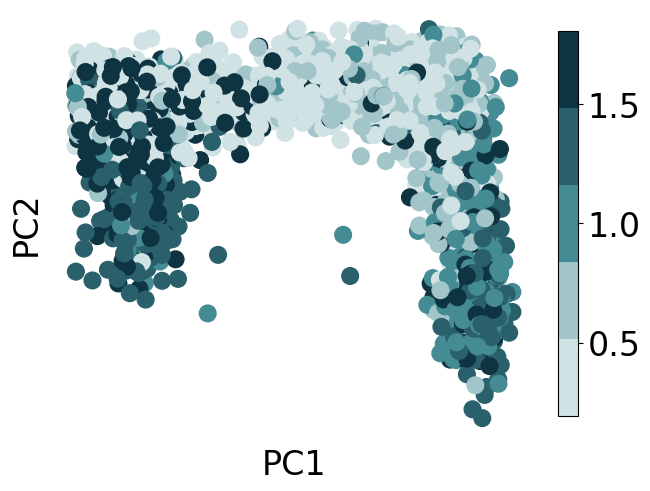

In [76]:
t_hat = Q0.sum(1)@np.linspace(0,2,m)
color_palette = ["#d1e2e5","#a2c5ca","#458b94","#2a606b","#0e3442"]
cmap_y = LinearSegmentedColormap.from_list("Teals", color_palette, N=5)

fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [77]:
traj_ws = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_ws = traj_ws.fit(X,warm_start=True,fit_tau=True,params={"r":rd},Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj_ws.compute_AIC(X,standard=False))

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [02:37<00:00,  1.57s/it]

-330.1419824219746


In [78]:
data['ws'] = copy.deepcopy(traj_ws)

In [79]:
traj = copy.deepcopy(traj_ws)
traj.model, traj.topo, traj.tau, traj.elbos[-1]

('two_species_ss',
 array([[0, 1, 2, 0]]),
 array([0.        , 1.12121258, 2.12121392, 3.        ]),
 -329.8161678856338)

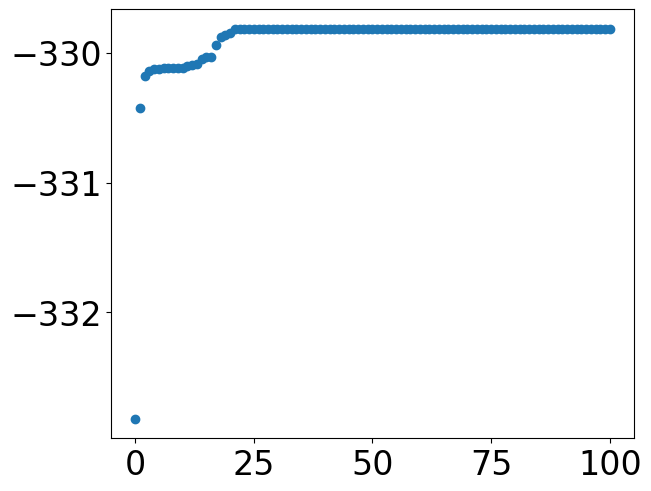

In [80]:
plt.plot(traj.elbos,'.')

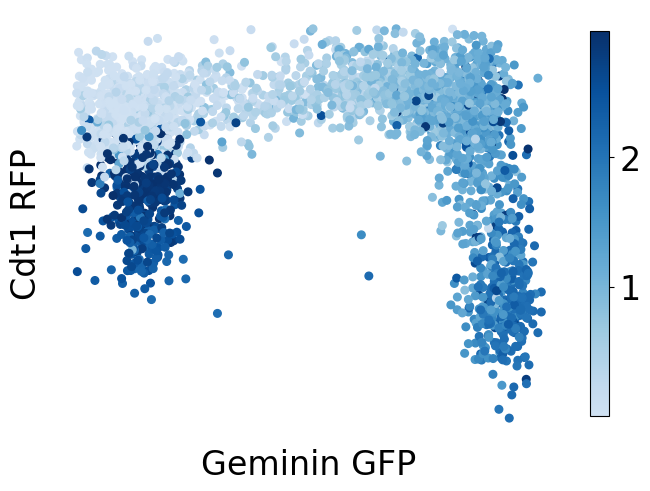

In [81]:
t_hat = np.sum(traj.Q@traj.t,axis=1)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,s=30,cmap=cmap_y);
ax.set_xlabel(r'Geminin GFP',fontsize=24)
ax.set_ylabel(r'Cdt1 RFP',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

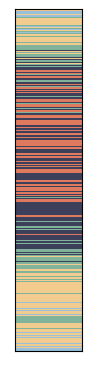

In [82]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])
ax.set_yticks([])

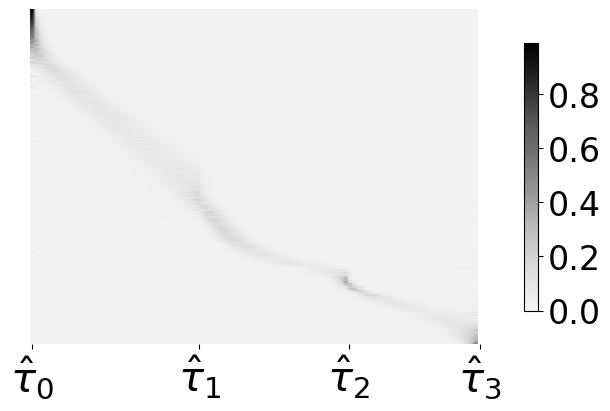

In [83]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$', r'$\hat{\tau}_3$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
    plt.rcParams['font.size'] = '16'

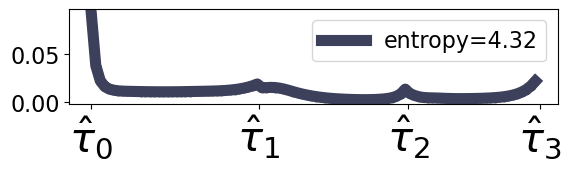

In [84]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.6,1.6))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$', r'$\hat{\tau}_3$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.legend()
plt.rcParams['font.size'] = '24'

Text(0, 0.5, 'Ending spliced value')

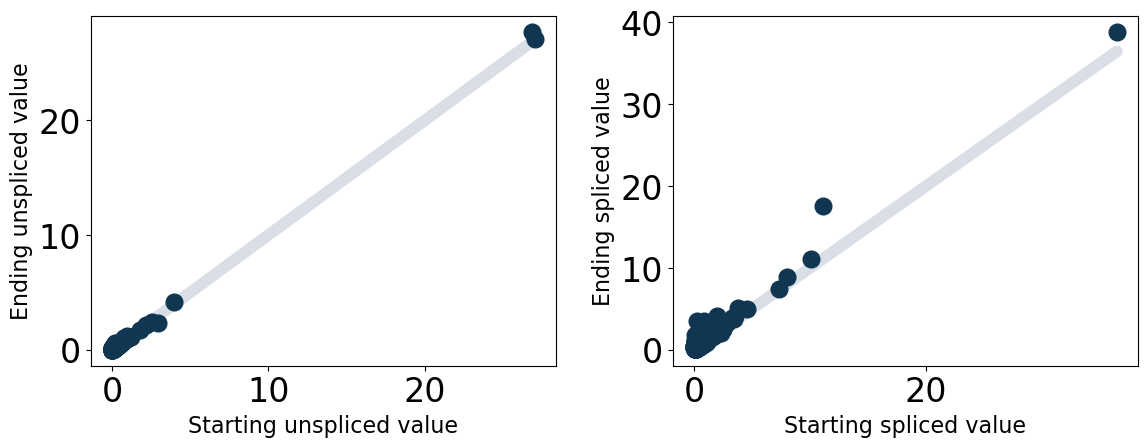

In [85]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)

fig, ax = plt.subplots(1,2,figsize=(12,5),tight_layout=True)
ax[0].plot(Y[0,0,:,0],Y[0,0,:,0],'#d9dee7',zorder=0,linewidth=8)
ax[0].scatter(Y[0,0,:,0],Y[0,-1,:,0],color='#113652')
ax[0].set_xlabel('Starting unspliced value',fontsize=16)
ax[0].set_ylabel('Ending unspliced value',fontsize=16)

ax[1].plot(Y[0,0,:,1],Y[0,0,:,1],'#d9dee7',zorder=0,linewidth=8)
ax[1].scatter(Y[0,0,:,1],Y[0,-1,:,1],color='#113652')
ax[1].set_xlabel('Starting spliced value',fontsize=16)
ax[1].set_ylabel('Ending spliced value',fontsize=16)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

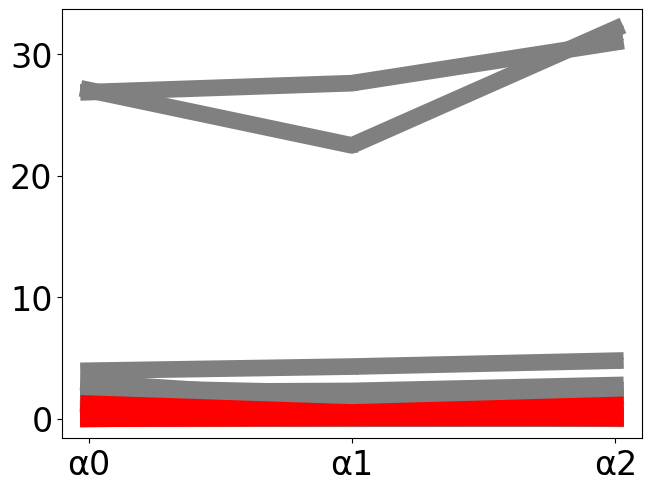

In [86]:
p=X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

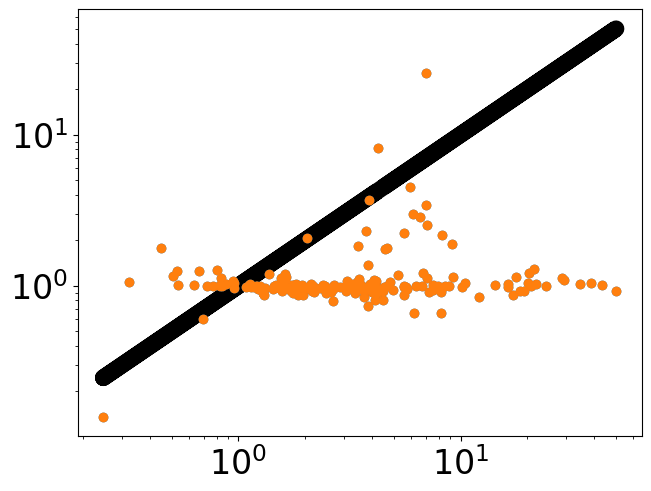

In [87]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

In [88]:
reasonable_idx = (np.abs(np.log10(traj.theta[:,-1]))<1) #& (np.log10(traj.theta[:,-1])<np.log10(50))

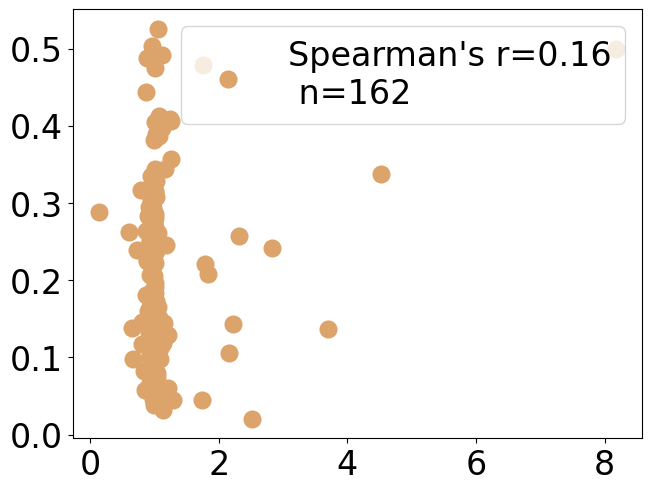

In [89]:
A = traj.theta[reasonable_idx,-1]
B = Battich_gamma[fitted_idx][reasonable_idx]
plot_cor(A,B)

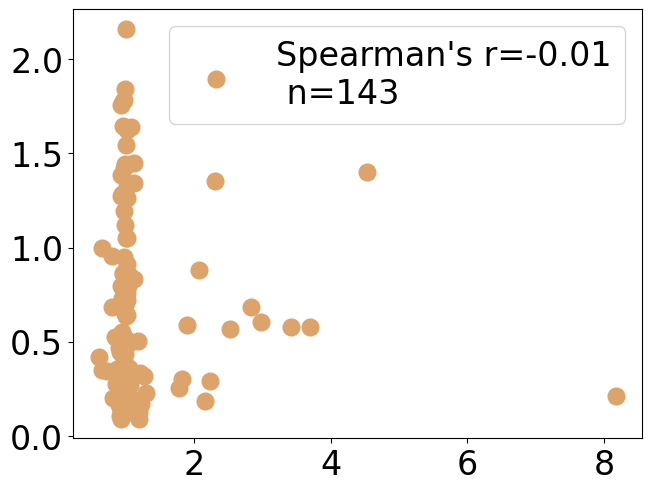

In [90]:
A = traj.theta[reasonable_idx,-1]
B = Schofield_gamma[fitted_idx][reasonable_idx]
plot_cor(A,B)

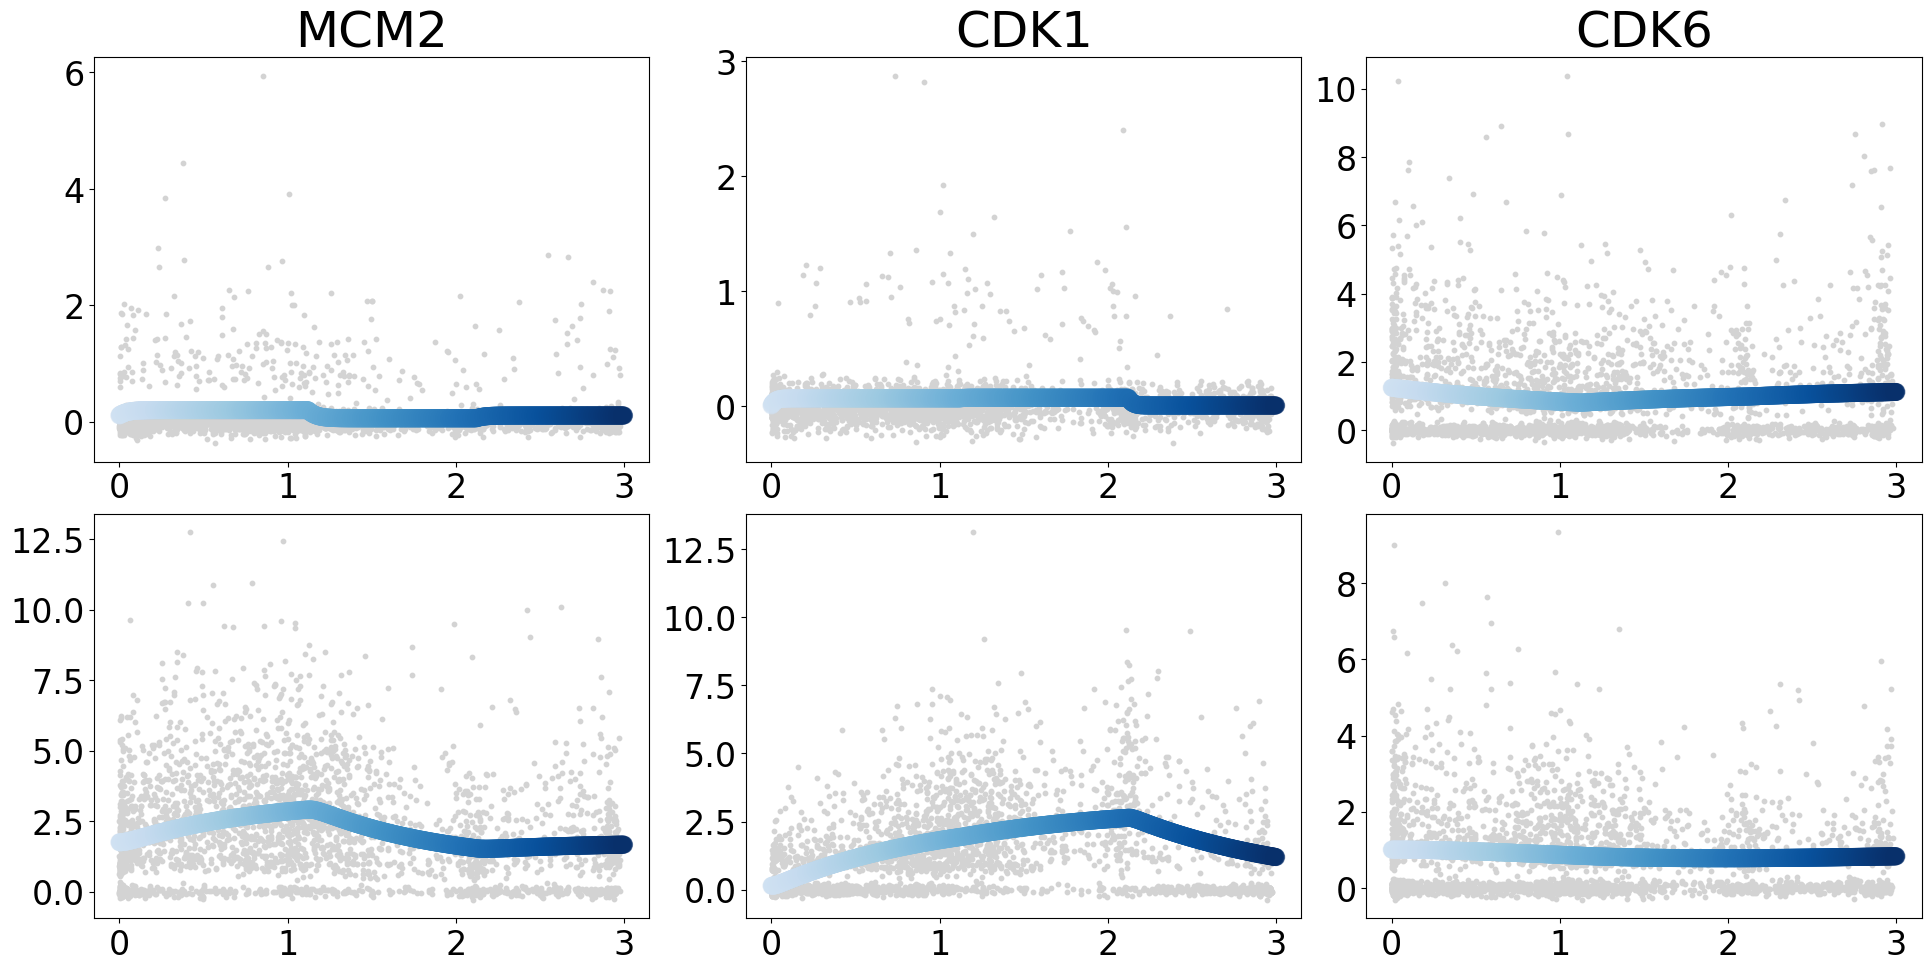

In [91]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

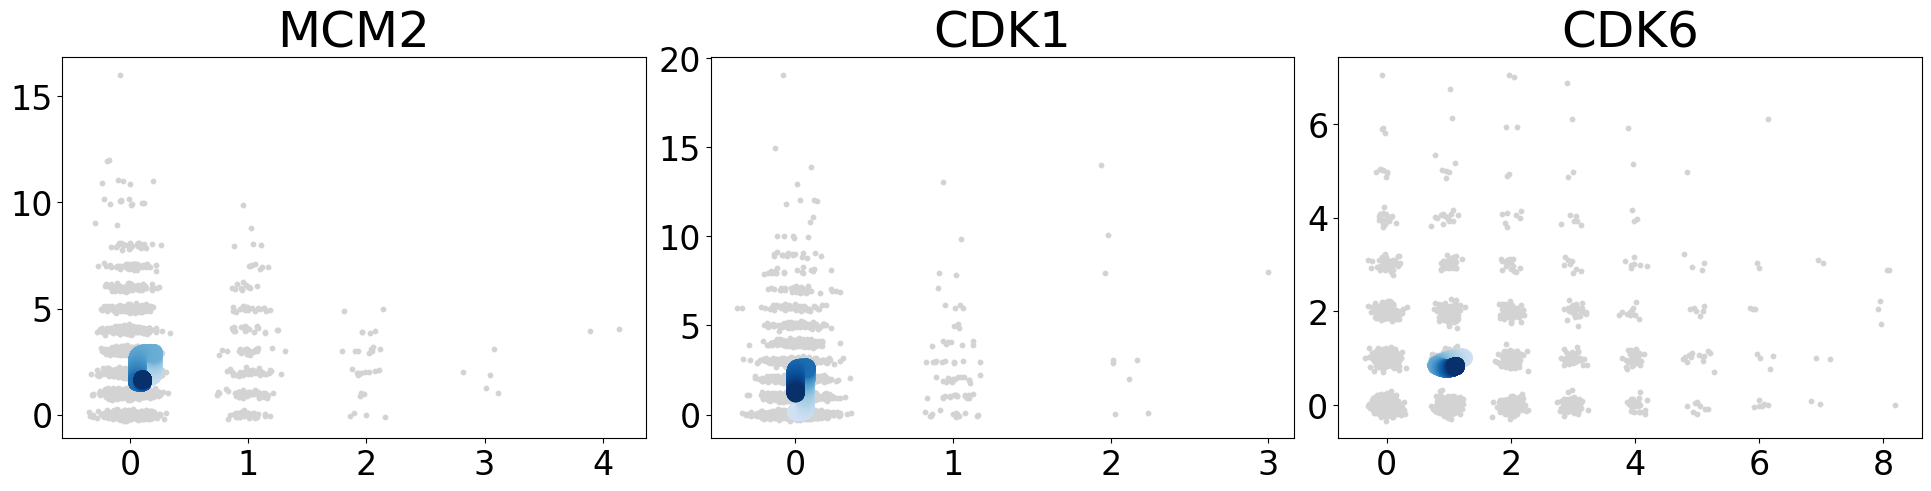

In [92]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

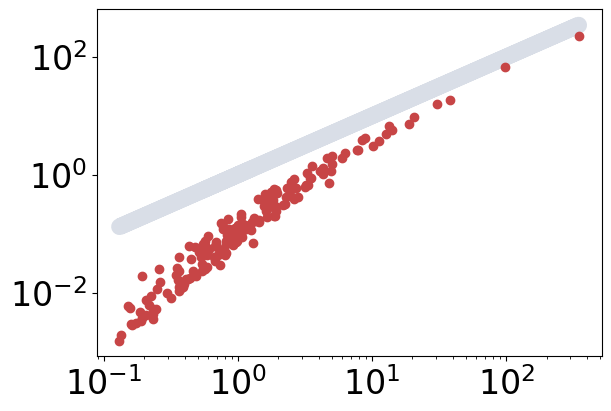

In [93]:
Y_hat = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)[0] 
Y = traj.params['r'][:,None,None]*np.sum(traj.Q[:,:,:,None,None] * Y_hat[None,:,:],axis=(1,2) )

X_var = X[:,:,1].var(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(X_var,X_var,color="#d9dee7");
ax.loglog(X_var,Y_var,'.',color="#c74546");

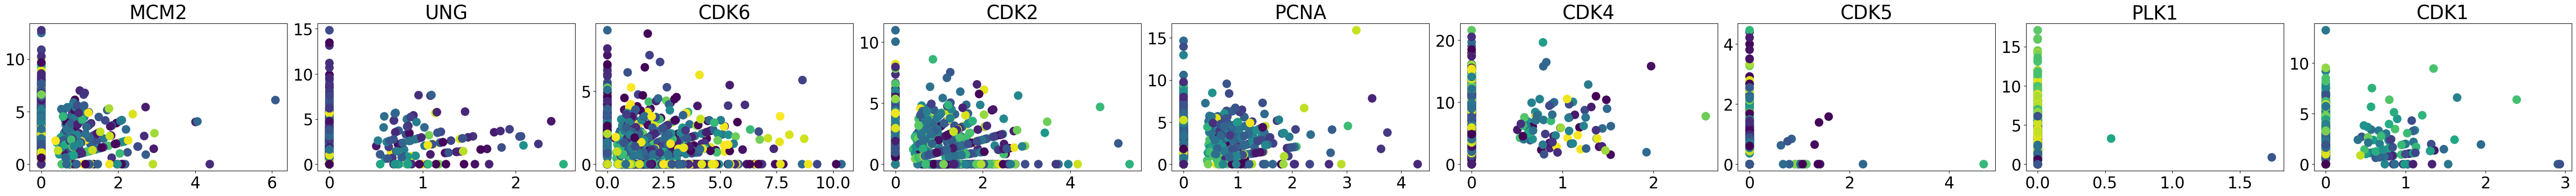

In [94]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

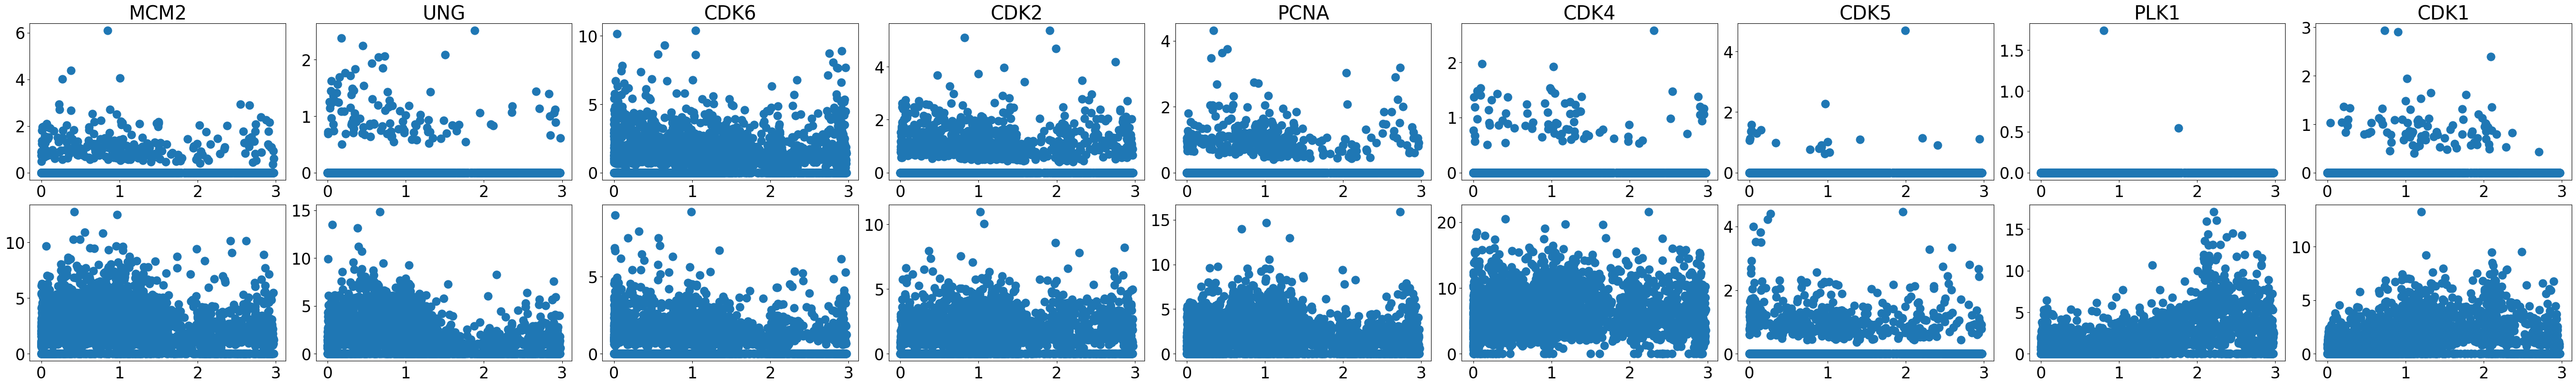

In [95]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

Text(0, 0.5, 'Density')

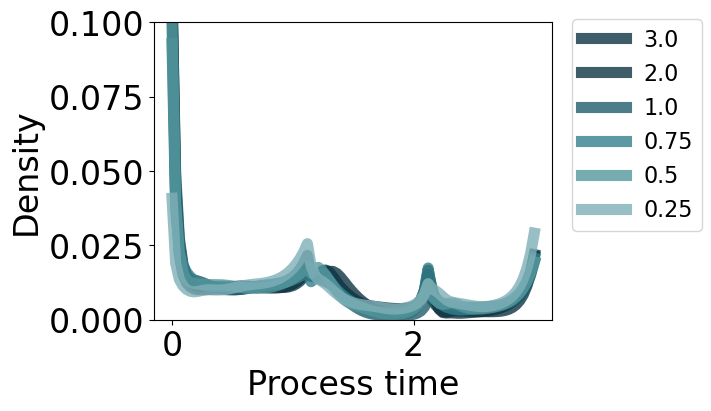

In [96]:
stages = adata.obs.time
Stages = np.flip((0.25,0.5,0.75,1,2,3))

color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Stages))

plt.figure(figsize=(7,4))
for i,stage in enumerate(Stages):
    idx = stages.isin([stage])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'-',alpha=0.8,linewidth=8,color=timepoint_cmp(6-i),label=str(stage))#+", n="+str(idx.sum()))
    
plt.ylim((0,0.1))
plt.legend(loc=(1.05,0.3),fontsize=16);
plt.xlabel('Process time',fontsize=24)
plt.ylabel('Density',fontsize=24)
#plt.title('Posterior distribution',fontsize=32)

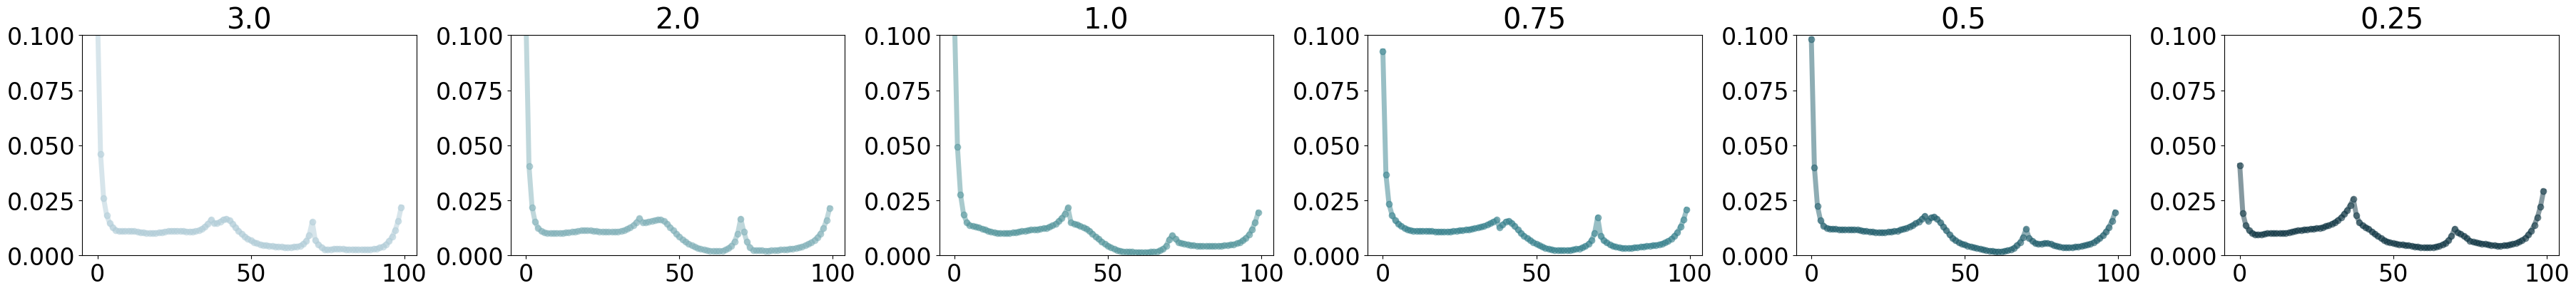

In [97]:
fig, ax = plt.subplots(1,len(Stages),figsize=(6*len(Stages),4))
for i,stage in enumerate(Stages):
    idx = stages.isin([stage])
    ax[i].plot(traj.Q[idx,0].mean(0),'.-',alpha=0.5,linewidth=5,label=stage,color=timepoint_cmp(i))
    ax[i].set_title(stage)
    ax[i].set_ylim([0,0.1])

In [98]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Random initializations

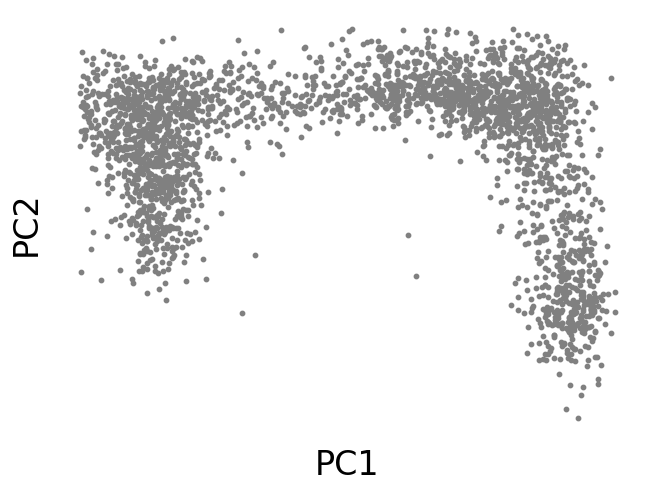

In [99]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [100]:
tau = (0,1,2,3)
topo = np.array([[0,1,2,0]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,params={"r":rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [101]:
data["ri"] = trajs

In [492]:
corrs = []
AICs = []
ref_t = traj_ws.Q[:,0] @ traj_ws.t
for traj in trajs:
    t_hat = traj.Q[:,0] @ traj.t
    corr = []
    for i in range(100):
        shifted_t_hat = t_hat - i/100 * traj.tau[-1]
        shifted_t_hat[shifted_t_hat<0] += 3
        corr.append(pearsonr(ref_t,shifted_t_hat)[0])
    corrs.append(np.max(corr))
    AICs.append( traj.compute_AIC(traj.X, standard=True) )

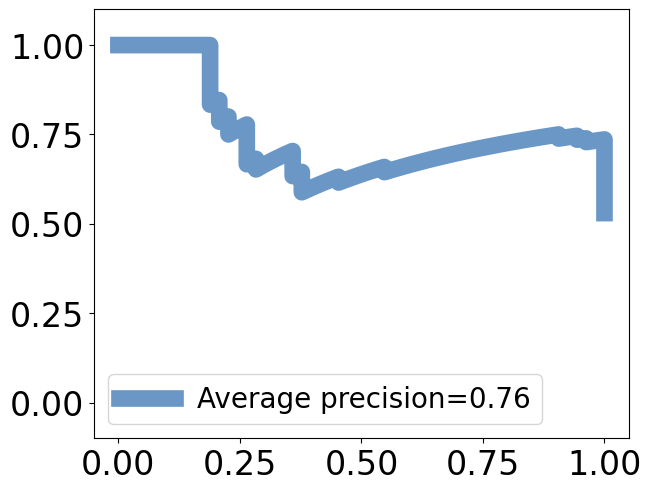

In [574]:
from sklearn.metrics import average_precision_score, precision_recall_curve

is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="Average precision="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=20)

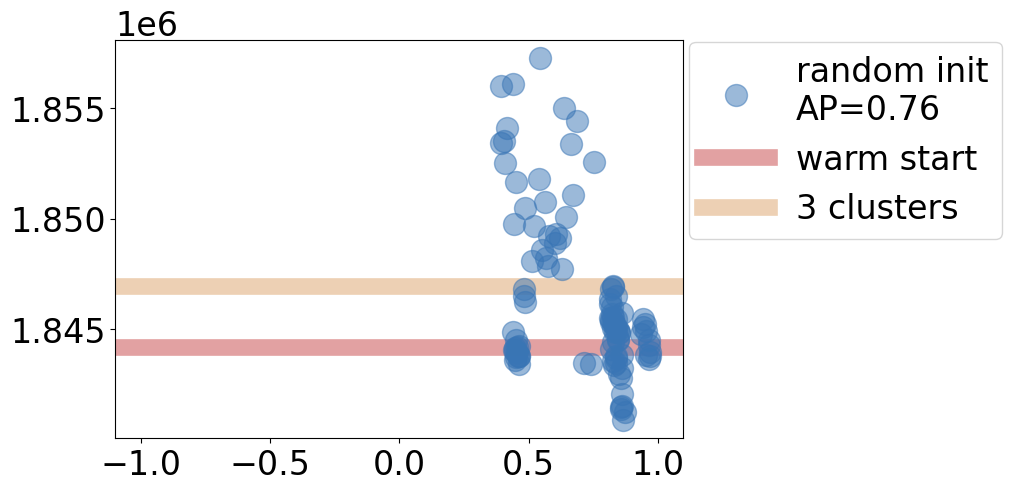

In [575]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(traj_ws.compute_AIC(traj.X, standard=True),linewidth=12,zorder=0,color='#c74546',alpha=0.5,label='warm start')
plt.axhline(PM.compute_AIC(traj.X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='3 clusters')
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

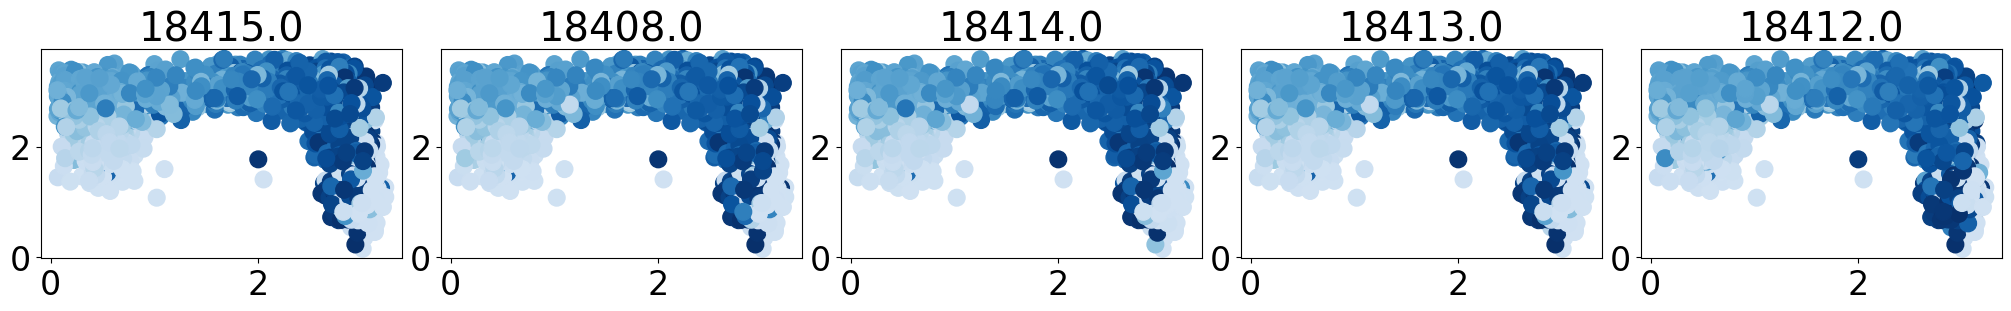

In [576]:
traj_idx = np.where(np.array(AICs)<1842000)[0]
fig, ax = plt.subplots(1,len(traj_idx),figsize=(4*len(traj_idx),3))
for i,ii in enumerate(traj_idx):
    traj = trajs[ii]
    #print(traj.tau)
    cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
    ax[i].scatter(xx[:,0],xx[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
    ax[i].set_title(AICs[ii]//100)

-329.55059170632944 -330.51742542007986


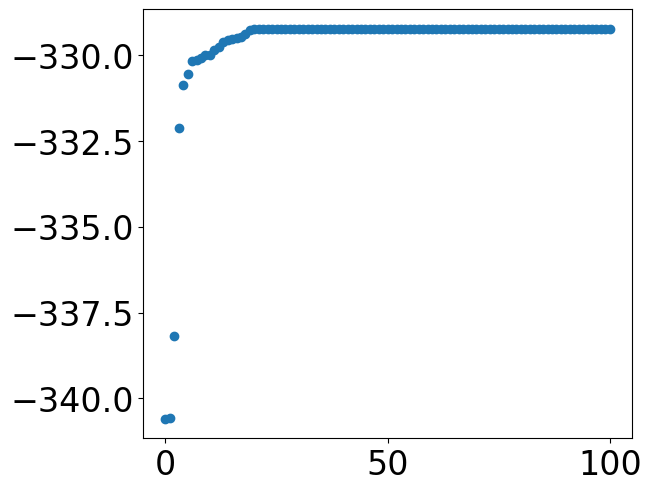

In [508]:
traj = trajs[np.argmin(AICs)]
X = traj.X
print(traj.compute_AIC(traj.X,standard=False),traj.compute_BIC(traj.X,standard=False))
plt.plot(traj.elbos[0],'.')

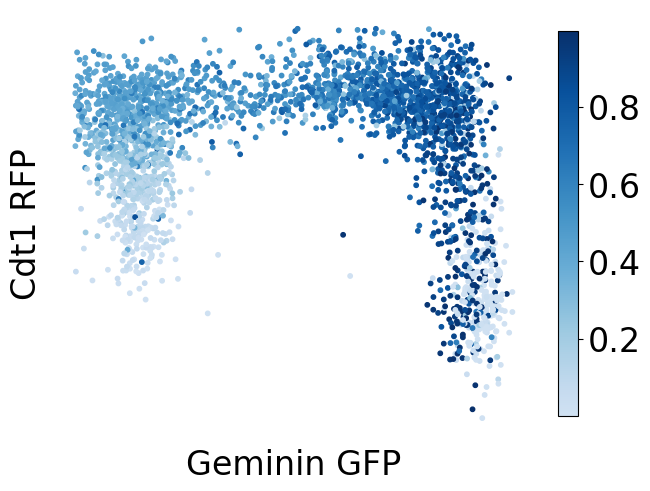

In [509]:
t_hat = np.sum(traj.Q@traj.t,axis=1)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(xx[:,0],xx[:,1],c=t_hat/3,cmap=cmap_y,s=10);
ax.set_xlabel(r'Geminin GFP',fontsize=24)
ax.set_ylabel(r'Cdt1 RFP',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

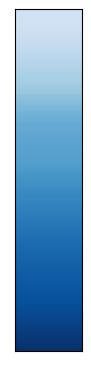

In [510]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = t_hat
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_y)
ax.set_xticks([])
ax.set_yticks([])

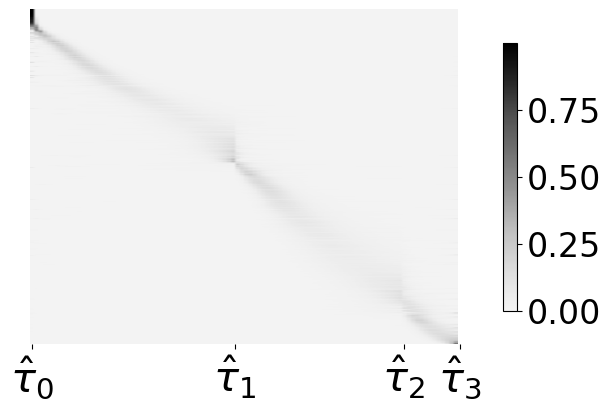

In [511]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$', r'$\hat{\tau}_3$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

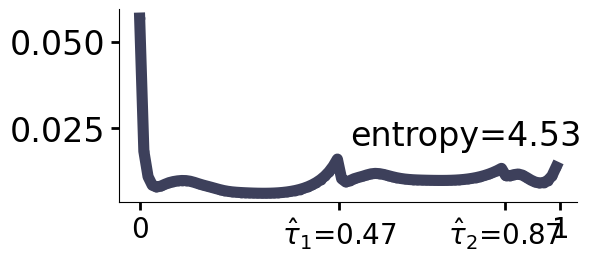

In [512]:
fig,ax = plt.subplots(figsize=(5.8,2.5))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8);
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],2)),r'$\hat{\tau}_2$='+str(np.around(traj.tau[2]/traj.tau[-1],2)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=20)
ax.text(50,0.02,"entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)),fontsize=legend_font)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

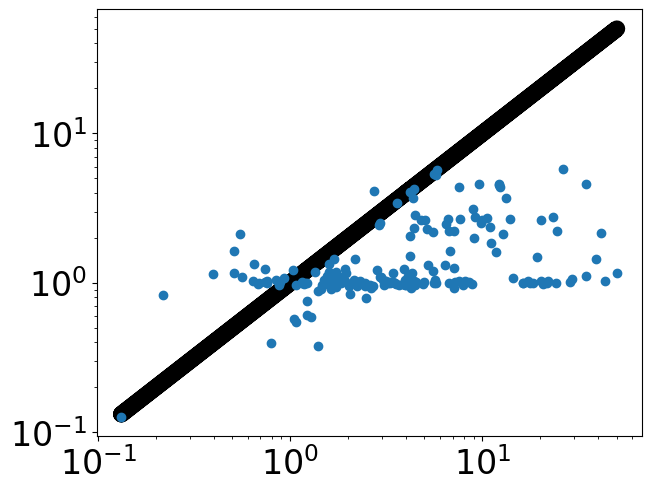

In [501]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

Text(0.02, 0.5, 'Ending values')

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  func(*args, **kwargs)


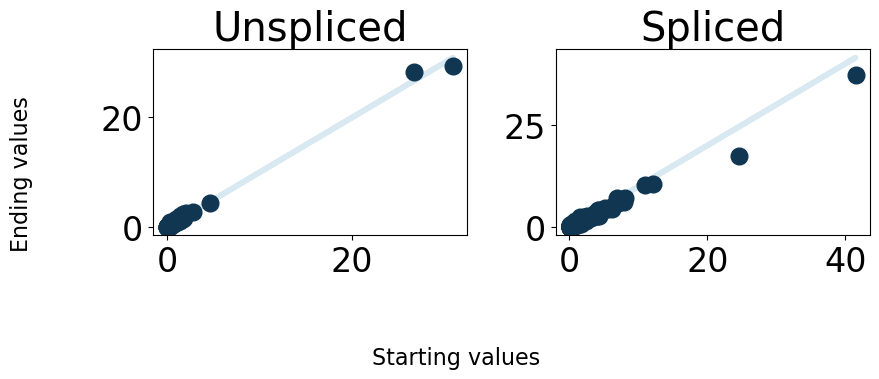

In [502]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
fig, ax = plt.subplots(1,2,figsize=(9,4),tight_layout=True)
ax[0].plot(Y[0,0,:,0],Y[0,0,:,0],'#d8e9f2',zorder=0,linewidth=4)
ax[0].scatter(Y[0,0,:,0],Y[0,-1,:,0],color='#113652')
ax[0].set_title("Unspliced")

ax[1].plot(Y[0,0,:,1],Y[0,0,:,1],'#d8e9f2',zorder=0,linewidth=4)
ax[1].scatter(Y[0,0,:,1],Y[0,-1,:,1],color='#113652')
ax[1].set_title("Spliced")
fig.supxlabel('Starting values',fontsize=16)
fig.supylabel('Ending values',fontsize=16)

Text(0, 0.5, 'Explained variance')

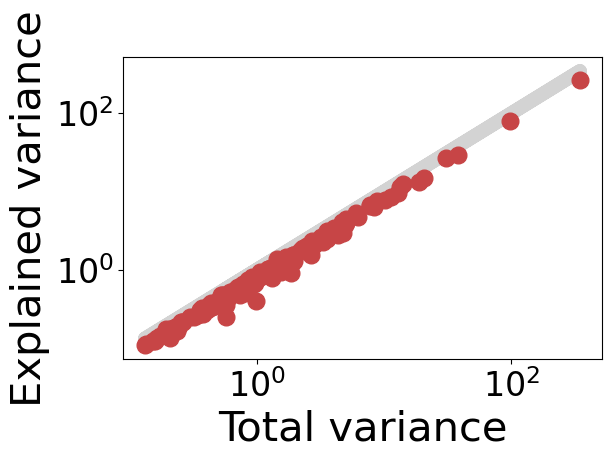

In [503]:
Y_grid = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)[0]
Y = traj.params['r'][:,None,None] * np.sum(traj.Q[:,:,:,None,None]* Y_grid[None,:],axis=(1,2)) 

mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.loglog(var,var,color='lightgray',zorder=0,linewidth=10)
plt.scatter(var,Y_var+Y_mean,color='#c74546')
plt.xlabel('Total variance',fontsize=label_font)
plt.ylabel('Explained variance',fontsize=label_font)

(array([35., 44., 26., 19., 18.,  9.,  7.,  7.,  3.,  6.,  1.,  2.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.04488944, 0.24749955, 0.45010966, 0.65271978, 0.85532989,
        1.05794   , 1.26055011, 1.46316023, 1.66577034, 1.86838045,
        2.07099057, 2.27360068, 2.47621079, 2.6788209 , 2.88143102,
        3.08404113, 3.28665124, 3.48926135, 3.69187147, 3.89448158,
        4.09709169, 4.2997018 , 4.50231192, 4.70492203, 4.90753214,
        5.11014226, 5.31275237, 5.51536248, 5.71797259, 5.92058271,
        6.12319282, 6.32580293, 6.52841304, 6.73102316, 6.93363327,
        7.13624338, 7.33885349, 7.54146361, 7.74407372, 7.94668383,
        8.14929394]),
 <BarContainer object of 40 artists>)

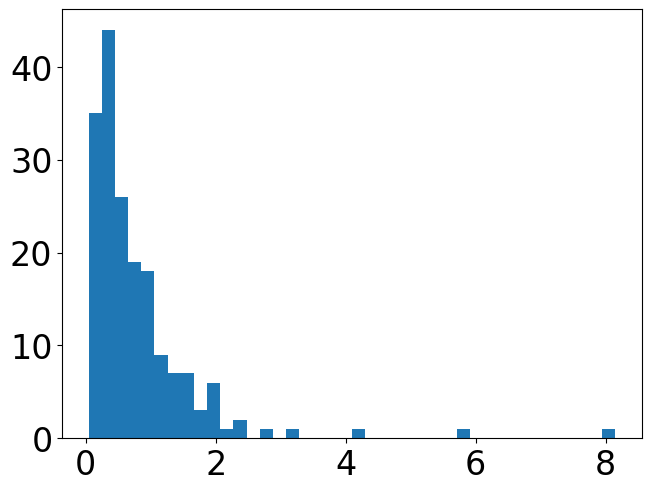

In [504]:
plt.hist((var-Y_var-Y_mean)/Y_mean**2,bins=40)

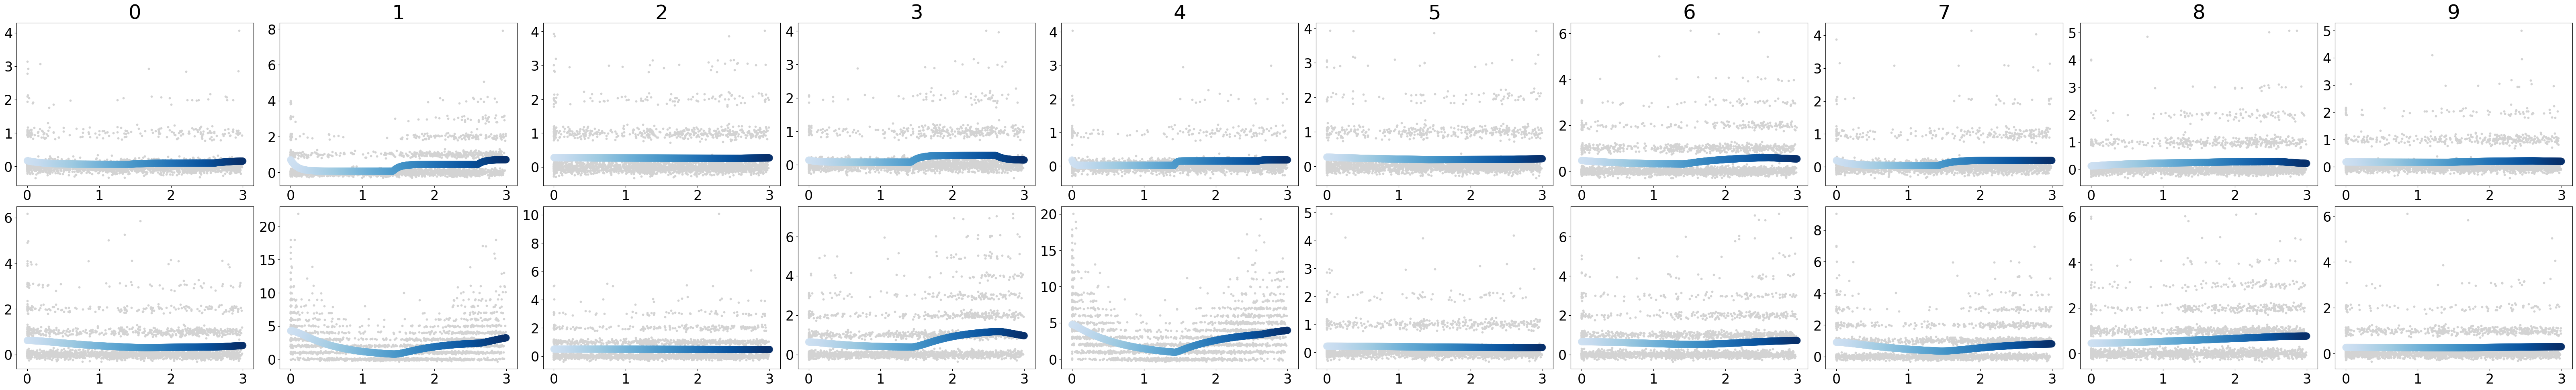

In [505]:
plot_y(traj);

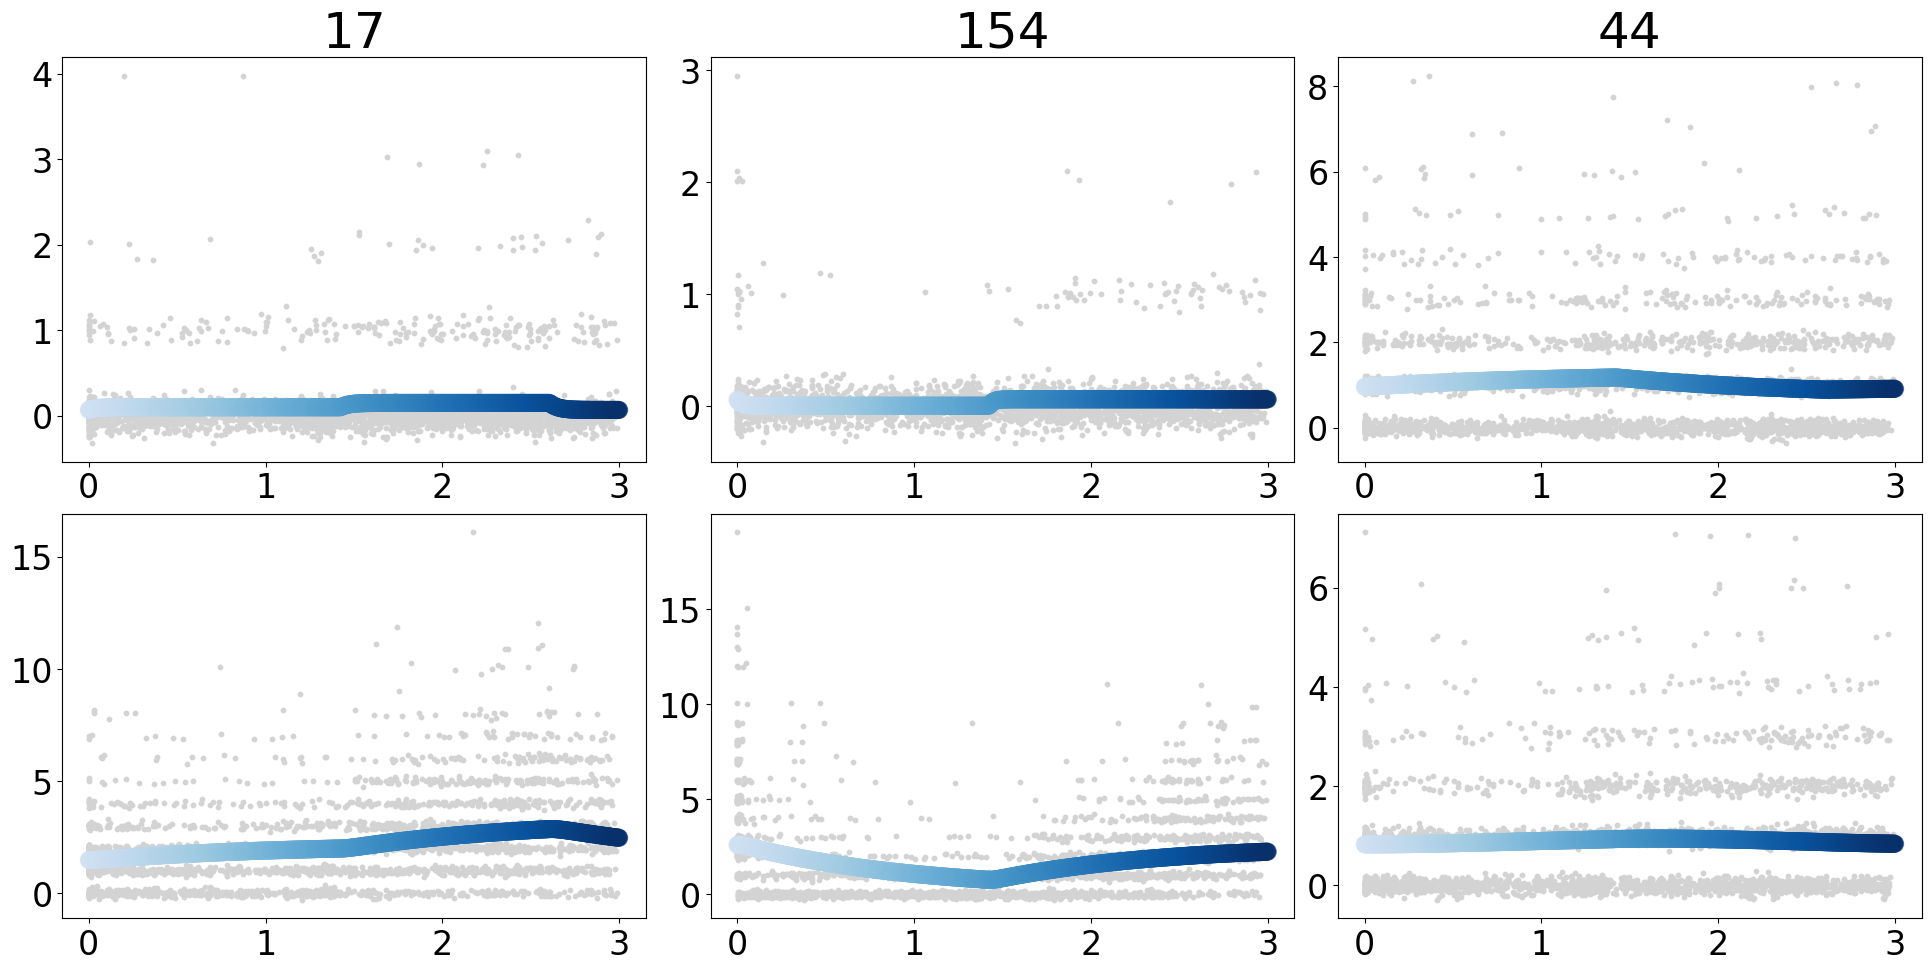

In [506]:
plot_y(traj,idx=plot_idx);

### two_species_ss_tau

In [235]:
theta0 = np.zeros((p,traj.n_states+traj.K+2))
theta0[:,:traj.n_states] = traj.theta[:,:traj.n_states]
theta0[:,-2:] = traj.theta[:,-2:]
theta0[:,traj.n_states:-2] = traj.tau[None,:-1]

traj_ri_tau_2 = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_ri_tau_2 = traj_ri_tau_2.fit(X,warm_start=True,theta=theta0,params={"r":rd,"lambda_tau":0.01,"bnd_tau":1},fit_tau=False,norm_Q=True,parallel=True,n_threads=10,epoch=100)
print(traj_ri_tau_2.compute_AIC(X,standard=False))

traj_ri_tau_1 = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_ri_tau_1 = traj_ri_tau_1.fit(X,warm_start=True,theta=theta0,params={"r":rd,"lambda_tau":0.001,"bnd_tau":1},fit_tau=False,norm_Q=True,parallel=True,n_threads=10,epoch=100)
print(traj_ri_tau_1.compute_AIC(X,standard=False))

traj_ri_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_ri_tau = traj_ri_tau.fit(X,warm_start=True,theta=theta0,params={"r":rd,"lambda_tau":0,"bnd_tau":1},fit_tau=False,norm_Q=True,parallel=True,n_threads=10,epoch=100)
print(traj_ri_tau.compute_AIC(X,standard=False))

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [09:09<00:00,  5.49s/it]


-328.1507732679737
Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [09:55<00:00,  5.95s/it]


-327.77475991517775
Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [09:01<00:00,  5.41s/it]

-327.6914952541007


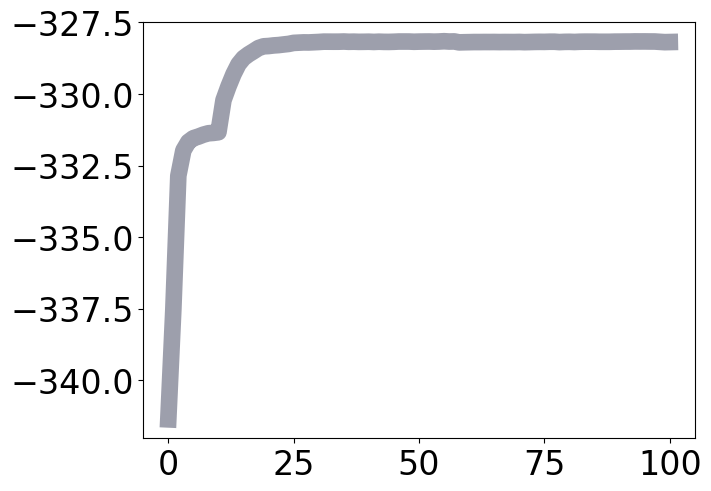

In [432]:
fig, ax = plt.subplots(1,1,figsize=(7,4.8))
plt.plot(traj_ri_tau.elbos,color='#3d405b',alpha=0.5)

In [740]:
traj = Trajectory(topo, tau, model="two_species_ss_tau",verbose=1)
traj = traj.fit(X,warm_start=True,theta=theta0,params={"r":rd,"lambda_tau":0,"bnd_tau":1},fit_tau=False,norm_Q=True,parallel=True,n_threads=10,epoch=100)
print(traj.compute_AIC(X,standard=False))

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [09:17<00:00,  5.58s/it]

-328.78424908614556


In [371]:
data["ri_tau"] = traj_ri_tau
data["ri_tau_1"] = traj_ri_tau_1
data["ri_tau_2"] = traj_ri_tau_2

In [769]:
traj = copy.deepcopy(data["ri_tau_1"])
traj.model, traj.topo, traj.tau, traj.params['lambda_tau']

('two_species_ss_tau',
 array([[0, 1, 2, 0]]),
 array([0.        , 1.42424431, 2.60606291, 3.        ]),
 0.001)

In [770]:
print(traj.theta[:,3:-2].mean(0))
traj.params['lambda_tau'] = 0.00
print(traj.compute_lower_bound(X))

[0.1091145  1.39627504 2.57781576]
-327.2215475378515


#### Scatterplots

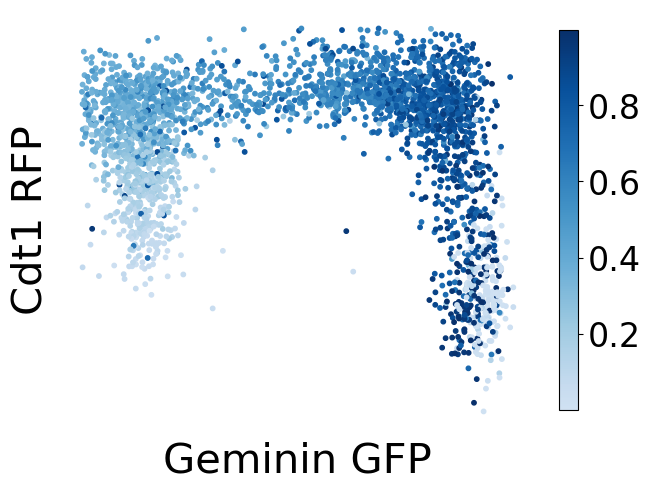

In [771]:
t_hat = np.sum(traj.Q@traj.t,axis=1)/traj.tau[-1]
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(xx[:,0],xx[:,1],c=t_hat,cmap=cmap_y,s=10);
ax.set_xlabel('Geminin GFP',fontsize=label_font)
ax.set_ylabel('Cdt1 RFP',fontsize=label_font)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

#### rd plot

('G1-S', 'S', 'G2-M', 'M', 'M-G1')


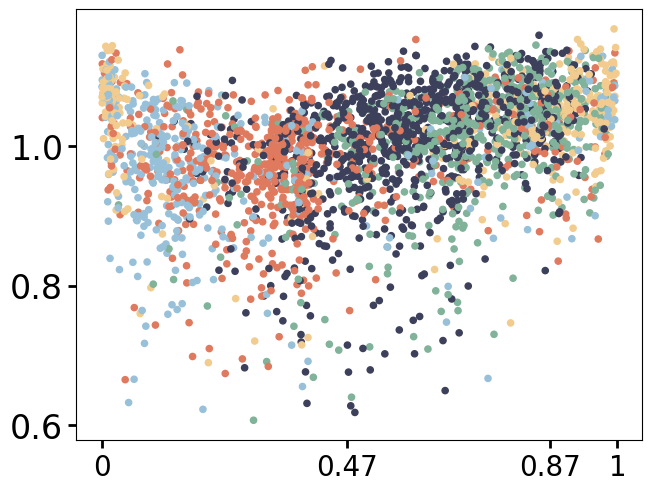

In [772]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(t_hat,adata.X.toarray().mean(1)/adata.X.toarray().mean(),s=20,c=cell_colors);
x_label_list = ['0', str(np.around(traj.tau[1]/traj.tau[-1],2)),str(np.around(traj.tau[2]/traj.tau[-1],2)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=20)
print(('G1-S', 'S', 'G2-M', 'M', 'M-G1'))

#### Posterior plots

[]

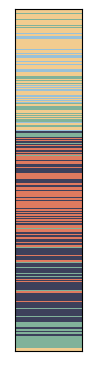

In [773]:
order = np.argsort(traj.Q.sum(1)@traj.t)
cluster = np.zeros(adata.n_obs)
cell_color = np.zeros((adata.n_obs,3))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
    cell_color[idx] = cmap_cluster(i)[:3]

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])
ax.set_yticks([])

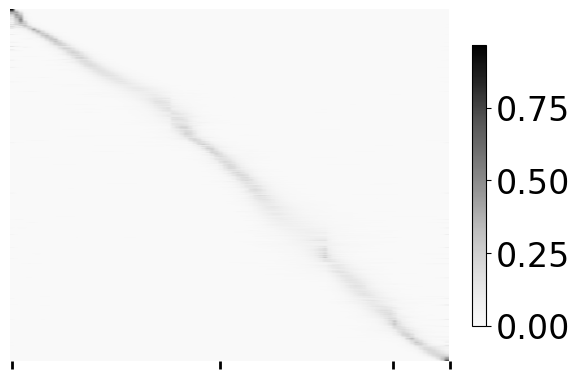

In [774]:
fig, ax = plt.subplots(1,1,figsize=(5.7,3.6))
cmap_Q = cmr.get_sub_cmap('Greys', 0.05, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []#[r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

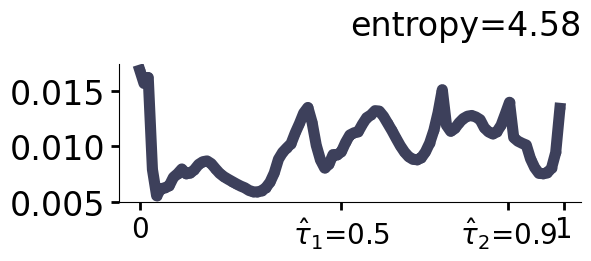

In [775]:
fig,ax = plt.subplots(figsize=(5.8,2.5))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8);
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],1)),r'$\hat{\tau}_2$='+str(np.around(traj.tau[2]/traj.tau[-1],1)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=20)
ax.text(50,0.02,"entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)),fontsize=legend_font)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

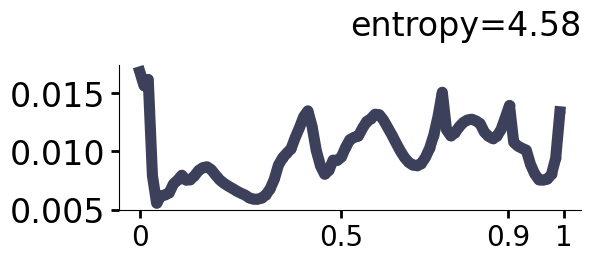

In [776]:
fig,ax = plt.subplots(figsize=(5.8,2.5))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8);
x_label_list = ['0', str(np.around(traj.tau[1]/traj.tau[-1],1)),str(np.around(traj.tau[2]/traj.tau[-1],1)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=20)
ax.text(50,0.02,"entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)),fontsize=legend_font)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

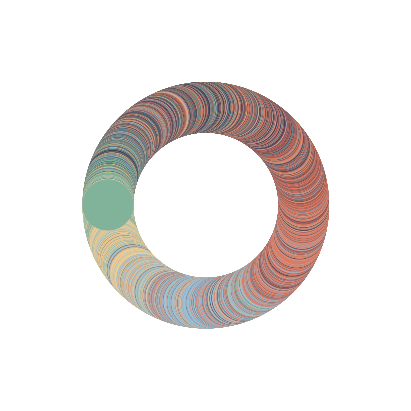

In [777]:
import numpy as np
import matplotlib.pyplot as plt

# Define the major and minor axes of the ellipse
major_axis = 1
minor_axis = 1

angles = np.linspace(0, 2 * np.pi, adata.n_obs) - np.pi

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4,4))

# Draw the ellipse ring and color each piece
x = major_axis * np.cos(angles)
y = major_axis * np.sin(angles)
ax.scatter(x, y, s=5000, marker='.',color=cell_color[order])
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

ax.set_axis_off()

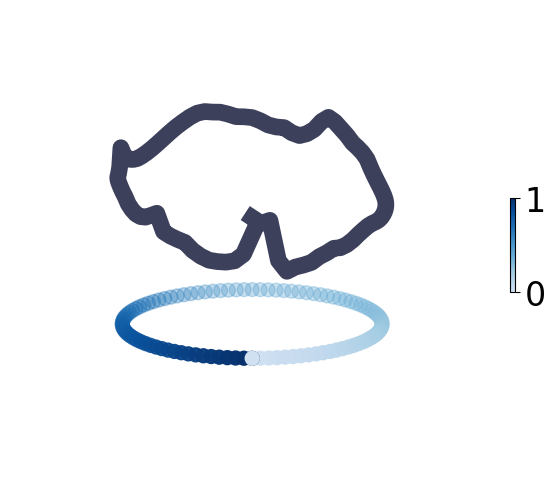

In [778]:
import numpy as np
import matplotlib.pyplot as plt

# Create an array of angles to form the ellipse ring
angles = np.linspace(0, 2 * np.pi, traj.m)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Draw the ellipse ring and color each piece
x = np.cos(angles)
y = np.sin(angles)
ax.scatter(0.5*x, y, -0.02*np.ones_like(x),cmap=cmap_y,s=100,c=np.arange(traj.m),zorder=0)
ax.plot(x, y, traj.Q.sum((0,1))/traj.Q.sum(),'-', color="#3d405b")

ax.view_init(elev=30,azim=0)

ax.set_axis_off()
# Set background color to be transparent
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.patch.set_facecolor('none')
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap_y),fraction=0.2,shrink=0.2)

plt.show()

In [779]:
import plotly.graph_objects as go

# Function to generate torus points
def generate_torus(R,r):
    u = np.linspace(0, 2 * np.pi, m)
    v = np.linspace(0, 2 * np.pi, n)
    u, v = np.meshgrid(u, v)
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    return x, y, z

# Parameters for the torus
major_radius = 5
minor_radius = 1.5

# Generate torus points
x, y, z = generate_torus(major_radius, minor_radius)

# Create a transparent surface plot with Plotly
fig = go.Figure(data=[go.Surface(x=x, y=y, z=z, colorscale=[[0, 'rgb(240,240,240)'], [1, 'rgb(0,0,0)']], surfacecolor=traj.Q.sum(1)[order],opacityscale=[[0, 1], [1, 1]])])

# Set layout properties to remove background elements
fig.update_layout(
    scene=dict(
        aspectmode="data",
        aspectratio=dict(x=1, y=1, z=1),
        xaxis=dict(backgroundcolor="rgba(0, 0, 0,0)",showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
        yaxis=dict(backgroundcolor="rgba(0, 0, 0,0)",showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
        zaxis=dict(backgroundcolor="rgba(0, 0, 0,0)",showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
        bgcolor='rgba(0,0,0,0)'),
    title='Transparent Torus with Surface Colors',
    paper_bgcolor='white',
    scene_bgcolor='white',
    plot_bgcolor='white',
)


# Save the plot as an HTML file
fig.write_html("figures/RPE1_torus_plot.html")

Text(0, 0.5, 'Probability mass')

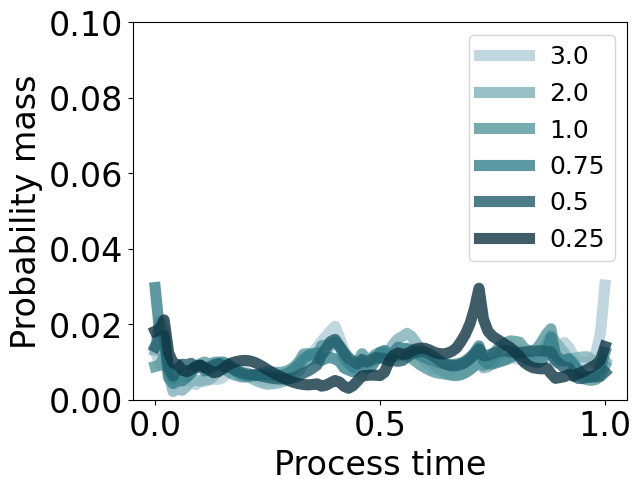

In [780]:
plt.figure(figsize=(6.4,4.8))
for i,stage in enumerate(Stages):
    idx = stages.isin([stage])
    plt.plot(traj.t/traj.tau[-1],traj.Q[idx,0].mean(0),'-',alpha=0.8,linewidth=8,color=timepoint_cmp(i),label=str(stage))#+", n="+str(idx.sum()))
    
plt.ylim((0,0.1))
plt.legend(fontsize=18);
plt.xlabel('Process time',fontsize=24)
plt.ylabel('Probability mass',fontsize=24)
#plt.title('Posterior distribution',fontsize=32)

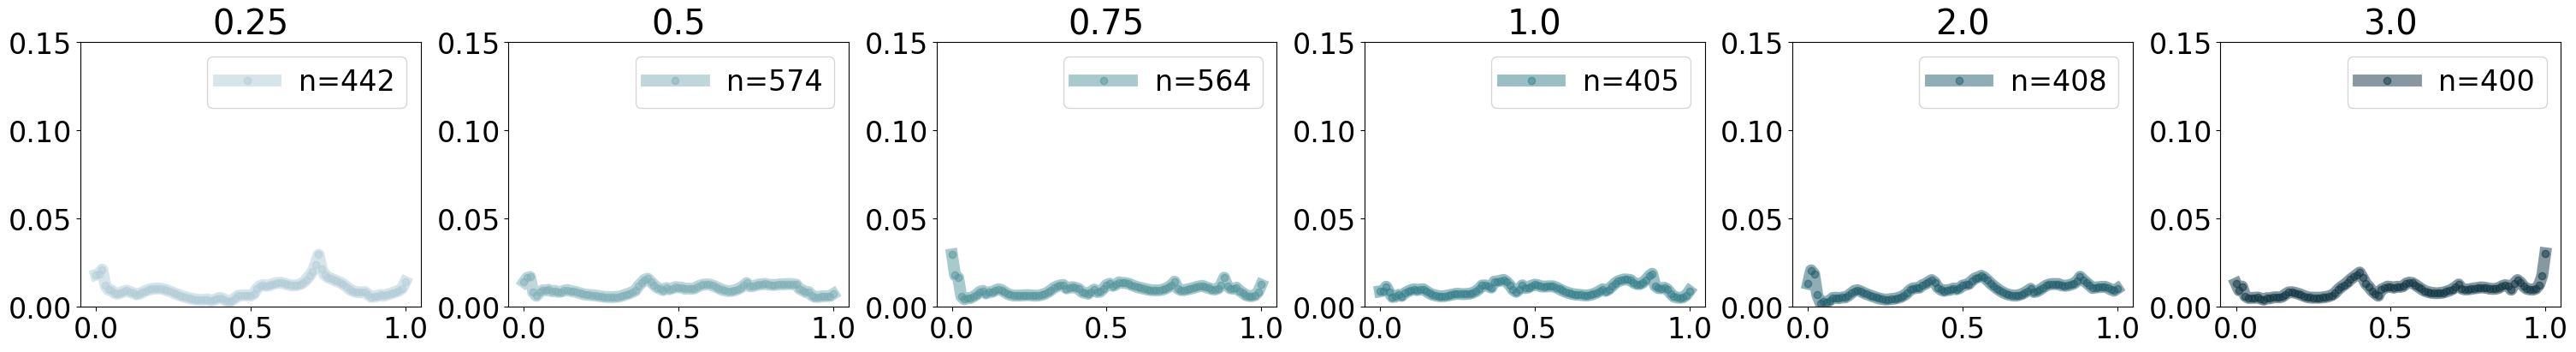

In [781]:
fig, ax = plt.subplots(1,len(Stages),figsize=(5*len(Stages),4))
for i,stage in enumerate(np.flip(Stages)):
    idx = stages.isin([stage])
    ax[i].plot(traj.t/traj.tau[-1],traj.Q[idx,0].mean(0),'.-',alpha=0.5,linewidth=10,color=timepoint_cmp(i),label="n="+str(np.sum(idx)))
    ax[i].set_title(stage)
    ax[i].set_ylim([0,0.15])
    ax[i].legend()

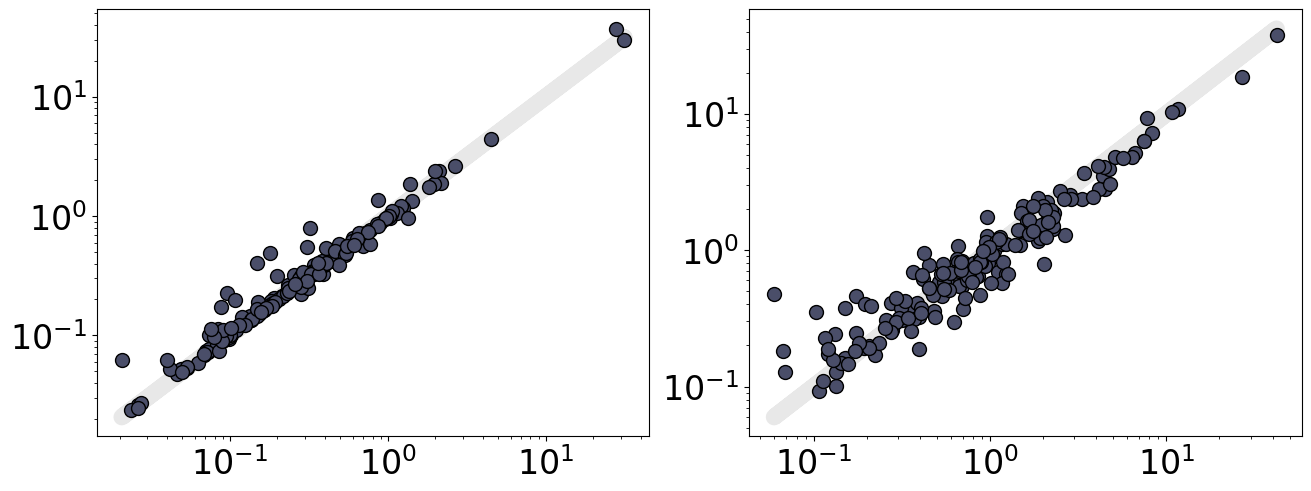

In [782]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
fig, ax = plt.subplots(1,2,figsize=(6.5*2,4.8))
ax[0].loglog(Y[0,0,:,0],Y[0,0,:,0],color='lightgray',zorder=0,linewidth=12,alpha=0.5)
ax[0].scatter(Y[0,0,:,0],Y[0,-1,:,0],color='#4a4e69',s=100,edgecolor='k')
ax[1].loglog(Y[0,0,:,1],Y[0,0,:,1],color='lightgray',zorder=0,linewidth=12,alpha=0.5)
ax[1].scatter(Y[0,0,:,1],Y[0,-1,:,1],color='#4a4e69',s=100,edgecolor='k')

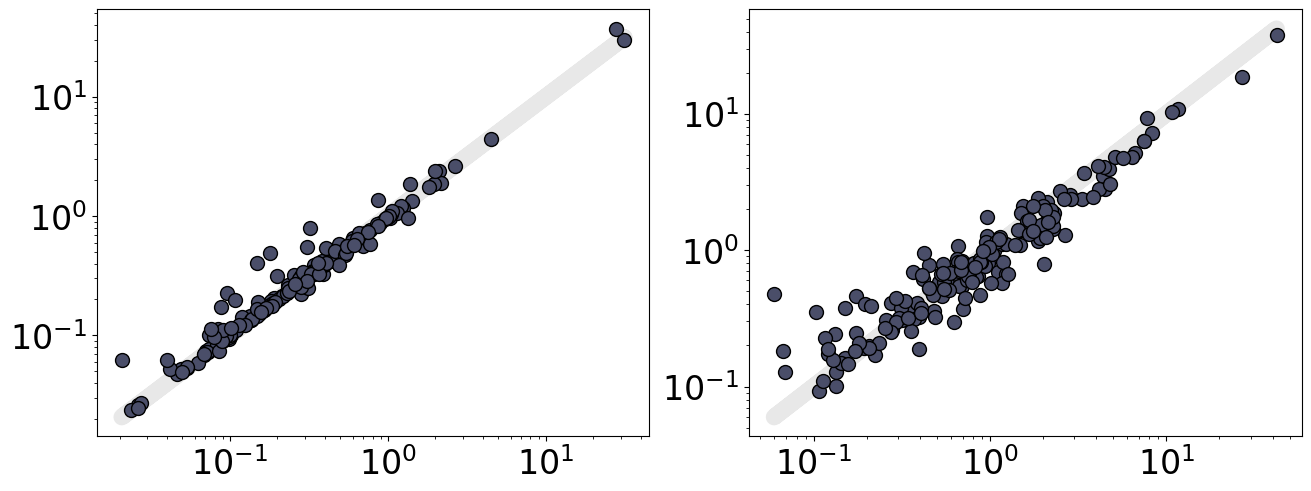

In [783]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
fig, ax = plt.subplots(1,2,figsize=(6.5*2,4.8))
ax[0].loglog(traj.theta[:,0],traj.theta[:,0],color='lightgray',zorder=0,linewidth=12,alpha=0.5)
ax[0].scatter(traj.theta[:,0],Y[0,-1,:,0],color='#4a4e69',s=100,edgecolor='k')
ax[1].loglog(Y[0,0,:,1],Y[0,0,:,1],color='lightgray',zorder=0,linewidth=12,alpha=0.5)
ax[1].scatter(Y[0,0,:,1],Y[0,-1,:,1],color='#4a4e69',s=100,edgecolor='k')

#### Remaining noise

Text(0, 0.5, 'Explained percentage')

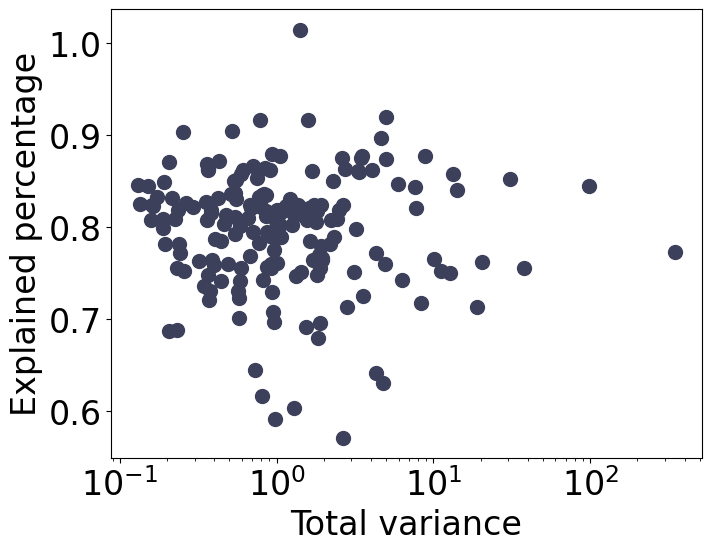

In [784]:
Y_grid = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)[0]
Y = traj.params['r'][:,None,None] * np.sum(traj.Q[:,:,:,None,None]* Y_grid[None,:],axis=(1,2)) 

mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(figsize=(7,5.4))
plt.scatter(var,(Y_var+Y_mean)/var,color='#3d405b',s=100)
plt.xscale('log')
plt.xlabel('Total variance',fontsize=24)
plt.ylabel('Explained percentage',fontsize=24)

In [785]:
P = (X-Y).sum(-1)

n,p = P.shape
P_cov = np.cov(P,rowvar=False)
P_mean = np.mean(P,axis=0)
P_rho = P_cov
sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print(sp)

0.012364414082274


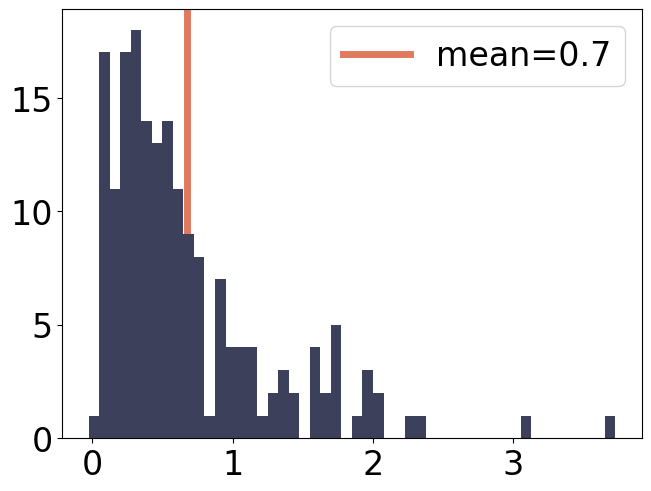

In [786]:
phi=(var-Y_var-Y_mean)/mean**2
plt.hist(phi,bins=50,color='#3d405b');
plt.axvline(x=phi.mean(),color='#e07a5f',label='mean='+str(np.around(phi.mean(),1)),linewidth=5,zorder=0);
plt.legend()

#### Gene selection

In [787]:
gene_logL, KL = traj.compute_gene_logL(traj.X,traj.Q)

In [788]:
p = len(gene_logL)
dlogL = gene_logL - cluster_gene_logL
dH = (cluster_KL-KL)/p
good_mask = (dlogL>dH) \
            & (traj.theta[:,-2]<100)  \
            & (traj.theta[:,-1]<100)
good_idx = np.arange(p)[good_mask]
print(good_mask.mean())
len(good_idx)

0.46153846153846156


84

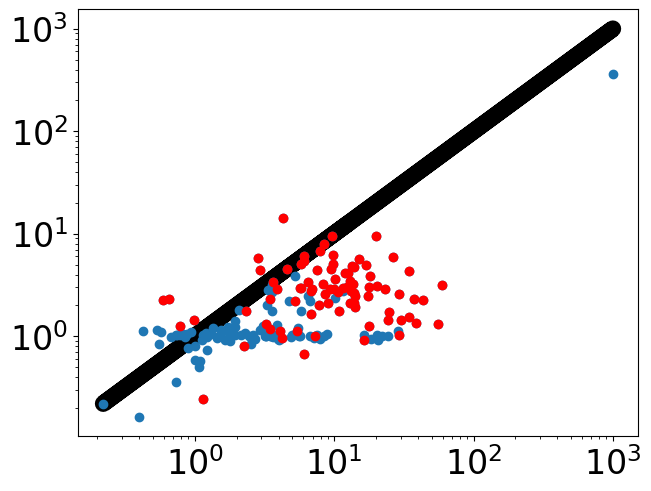

In [789]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')
plt.loglog(traj.theta[good_idx,-2],traj.theta[good_idx,-1],'r.')

13.925373277375654 4.099391287384926


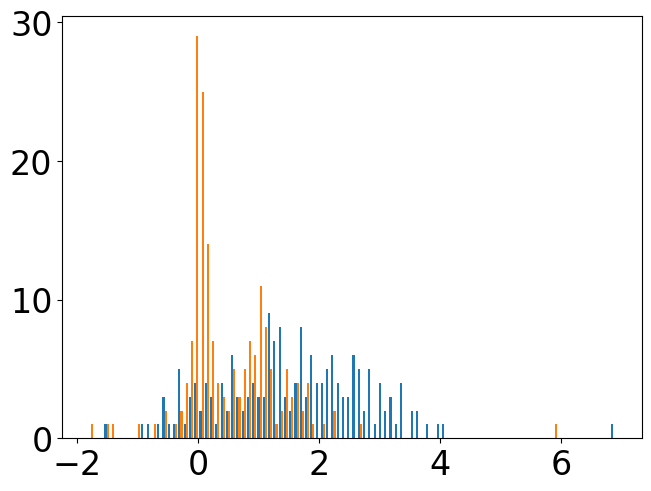

In [790]:
plt.hist([np.log(traj.theta[:,-2]),np.log(traj.theta[:,-1])],bins=100)
print(traj.theta[:,-2].mean(),traj.theta[:,-1].mean())

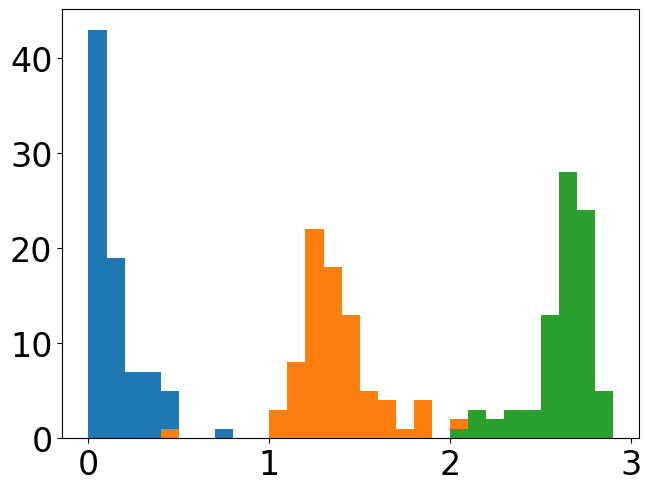

In [791]:
plt.hist(traj.theta[good_idx,-5],bins=np.arange(0,3,0.1));
plt.hist(traj.theta[good_idx,-4],bins=np.arange(0,3,0.1));
plt.hist(traj.theta[good_idx,-3],bins=np.arange(0,3,0.1));

#### Degradation rates comparison

In [792]:
import numpy.ma as ma

def plot_cor(A,B,ccc=False,color="#81b29a"):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    fig, ax = plt.subplots(figsize=(10.5,4.8))
    lims = [np.minimum(np.min(A[msk]),np.min(B[msk])),np.maximum(np.max(A[msk]),np.max(B[msk]))]
    ax.loglog(lims,lims,color='lightgray',alpha=0.5)
    ax.scatter(A[msk],B[msk], color=color, edgecolors='gray',s=100,\
               label="Pearson's r="+str(np.round(pearsonr(np.log(X),np.log(Y)).statistic,2))+"\nCCC="+str(np.round(CCC(X,Y),2))+"\nn="+str(np.sum(msk)));
    plt.legend(fontsize=legend_font,loc=(1.01,0.65))

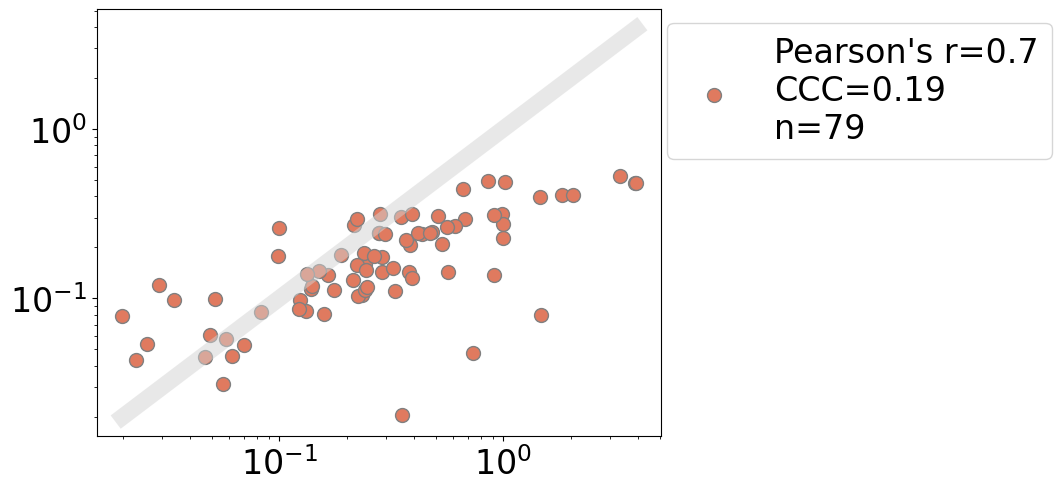

In [793]:
B = Battich_gamma[fitted_idx][good_idx]
A = (traj.X[:,:,0].mean(0)/traj.X[:,:,1].mean(0))[good_idx]
plot_cor(A,B,ccc=False,color="#e07a5f")

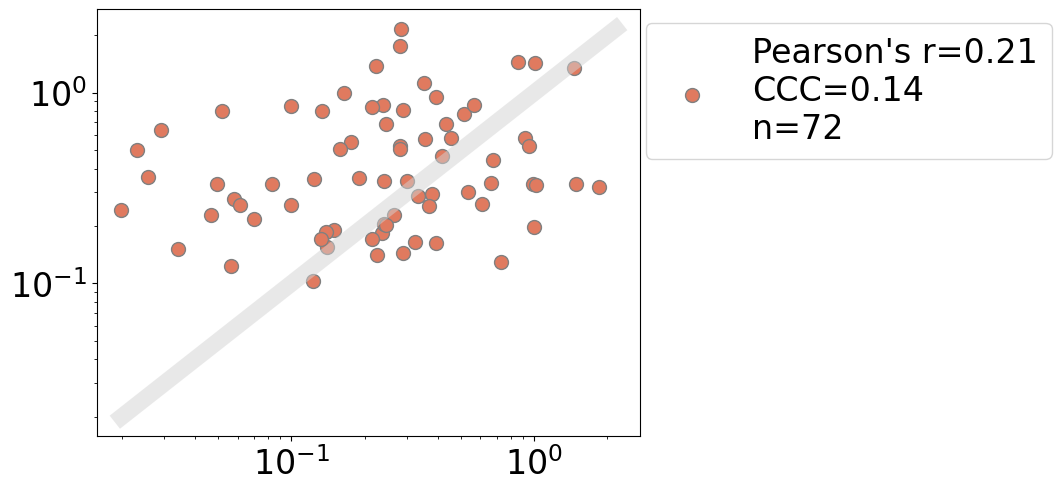

In [794]:
B = Schofield_gamma[fitted_idx][good_idx]
A = (traj.X[:,:,0].mean(0)/traj.X[:,:,1].mean(0))[good_idx]
plot_cor(A,B,ccc=False,color="#e07a5f")

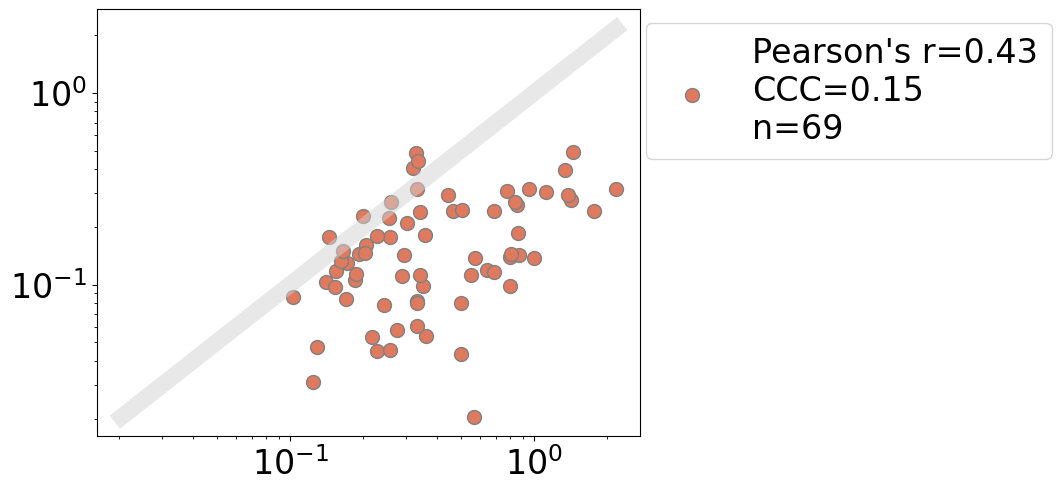

In [795]:
B = Battich_gamma[fitted_idx][good_idx]
A = Schofield_gamma[fitted_idx][good_idx]
plot_cor(A,B,ccc=False,color="#e07a5f")

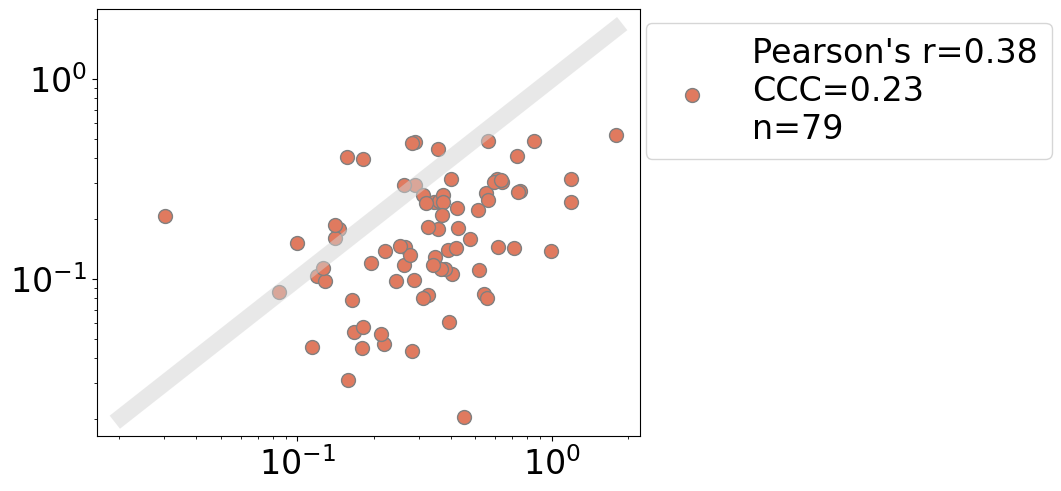

In [796]:
A = traj.theta[good_idx,-1]/8
B = Battich_gamma[fitted_idx][good_idx]
plot_cor(A,B,color="#e07a5f")

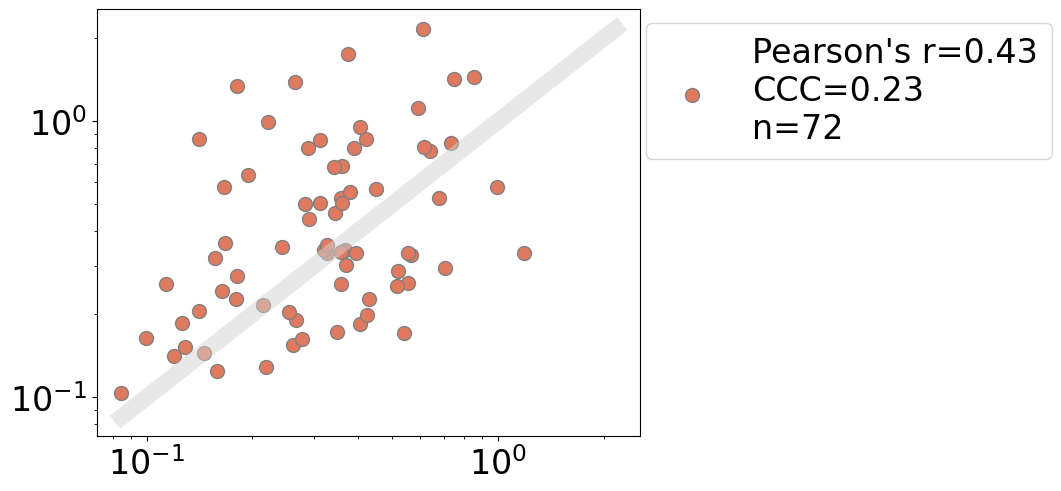

In [797]:
A = traj.theta[good_idx,-1]/8
B = Schofield_gamma[fitted_idx][good_idx]
plot_cor(A,B,ccc=False,color="#e07a5f")

In [799]:
alpha = traj.theta[good_idx,:3]
DE_mask = (np.max(alpha,axis=1)/np.min(alpha,axis=1)>26) & (np.min(alpha,axis=1)>0.01)
DE_idx = np.arange(p)[good_idx][DE_mask]
DE_idx

array([ 14,  29,  66, 107, 131])

In [800]:
fitted_genes[DE_idx]

Index(['ASPM', 'TPX2', 'KIF14', 'KNL1', 'HMGA2'], dtype='object')

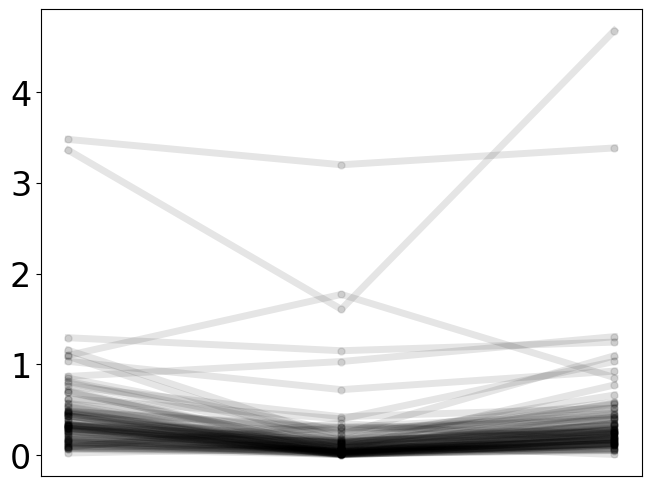

In [801]:
plt.rcParams['font.size'] = '24'
fig,ax = plt.subplots(1,1)
for j in good_idx:
    ax.plot(np.log1p(traj.theta[j,[0,1,2]]),'.-',linewidth=5,markersize=10,color='k',alpha=0.1)

ax.set_xticks([]);
#x_label_list = ['α0', 'α1', 'α2']
#ax.set_xticklabels(x_label_list)

#### Phase plots

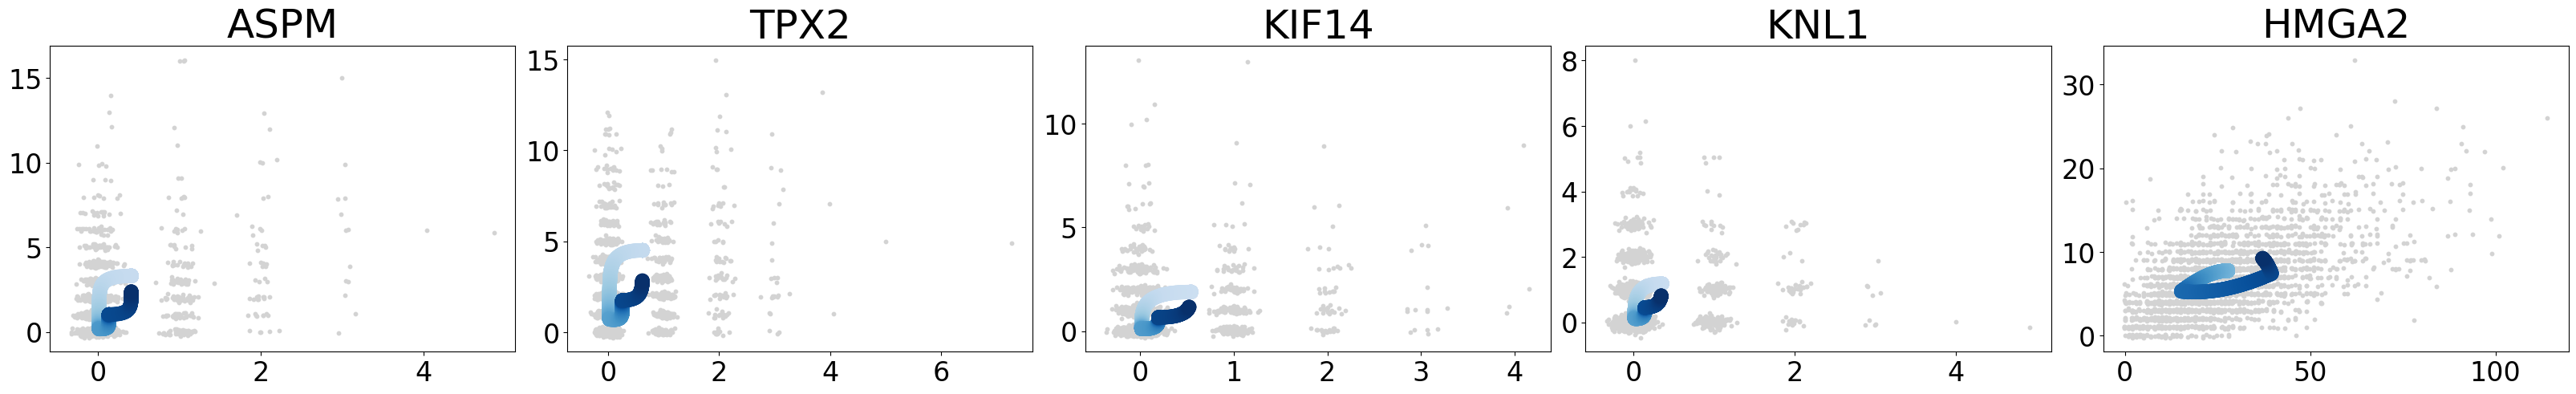

In [802]:
plot_phase(traj,idx=DE_idx,gene_name=fitted_genes);

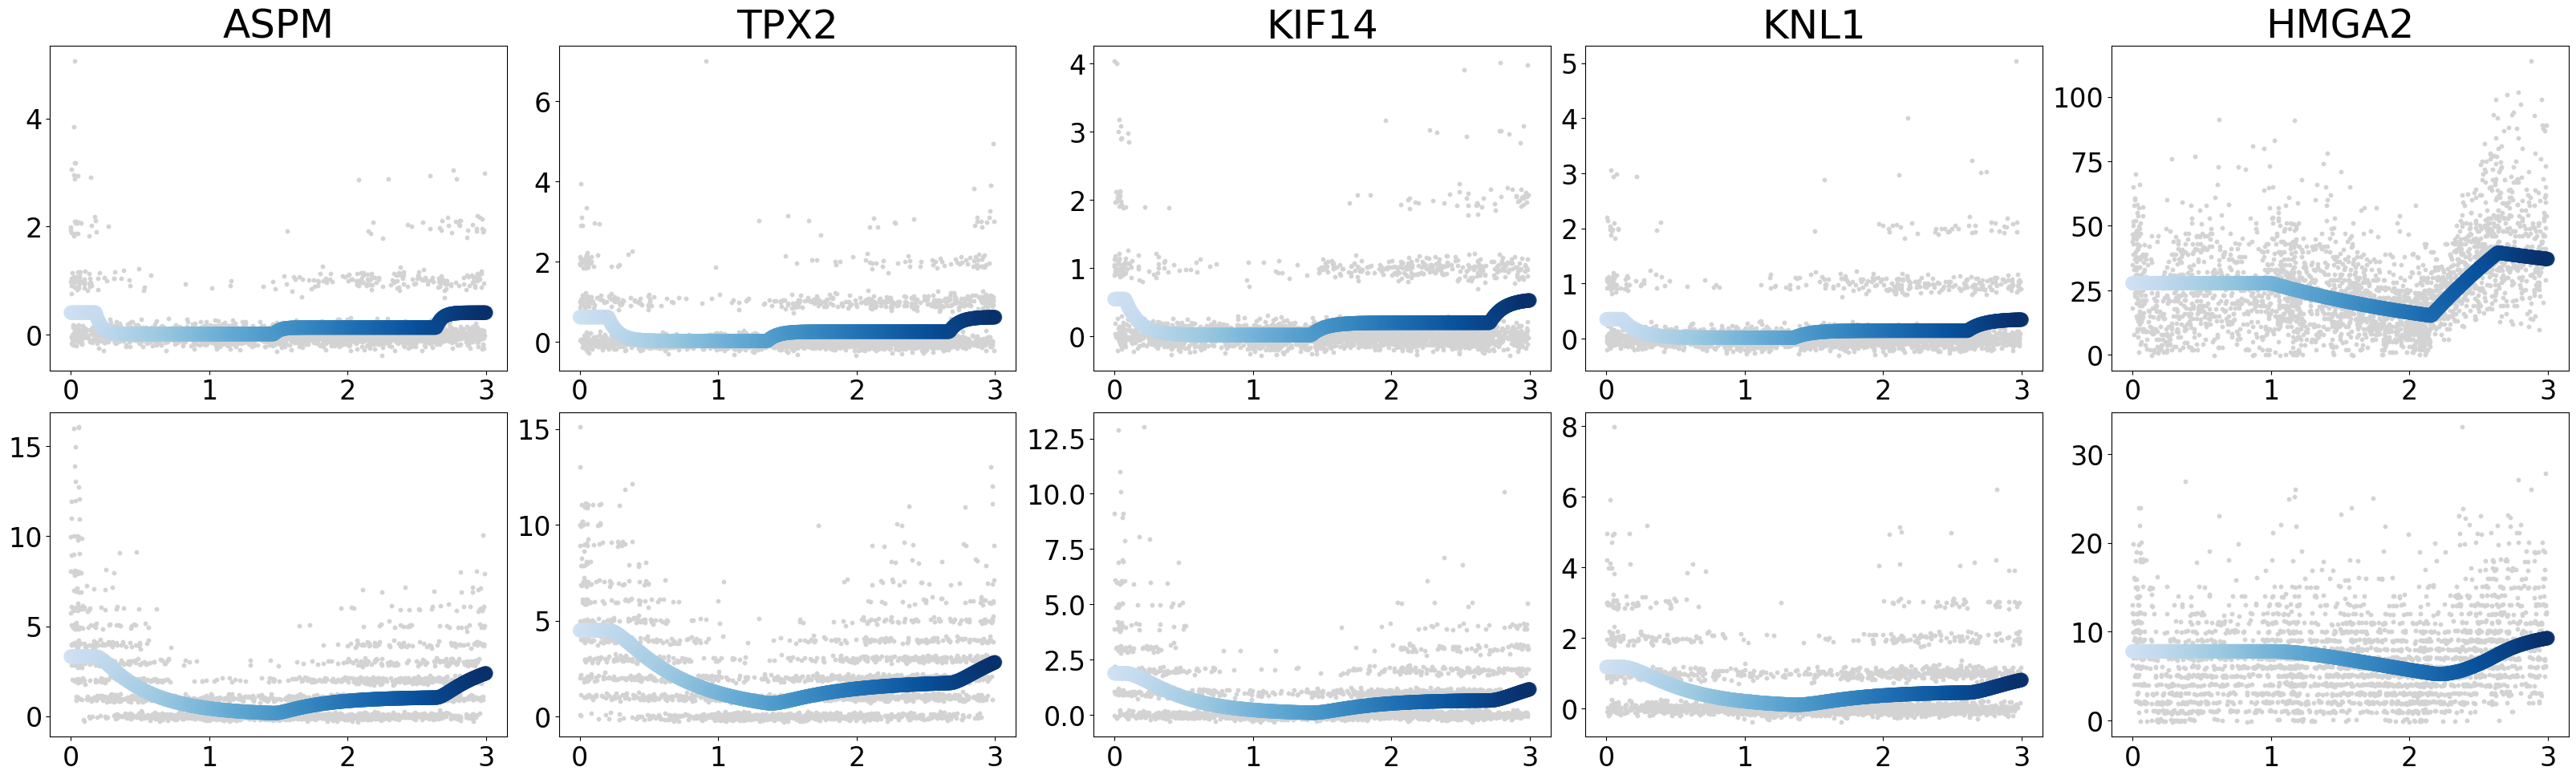

In [803]:
plot_y(traj,idx=DE_idx,gene_name=fitted_genes);

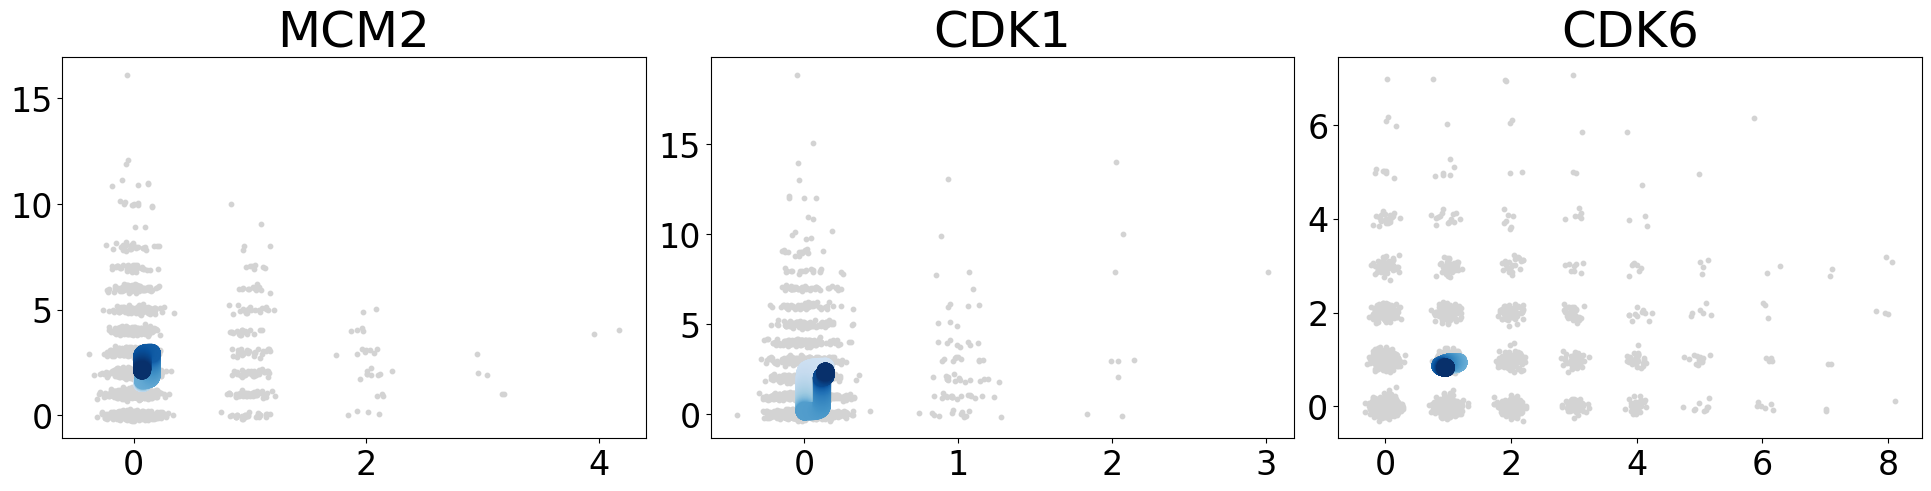

In [804]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

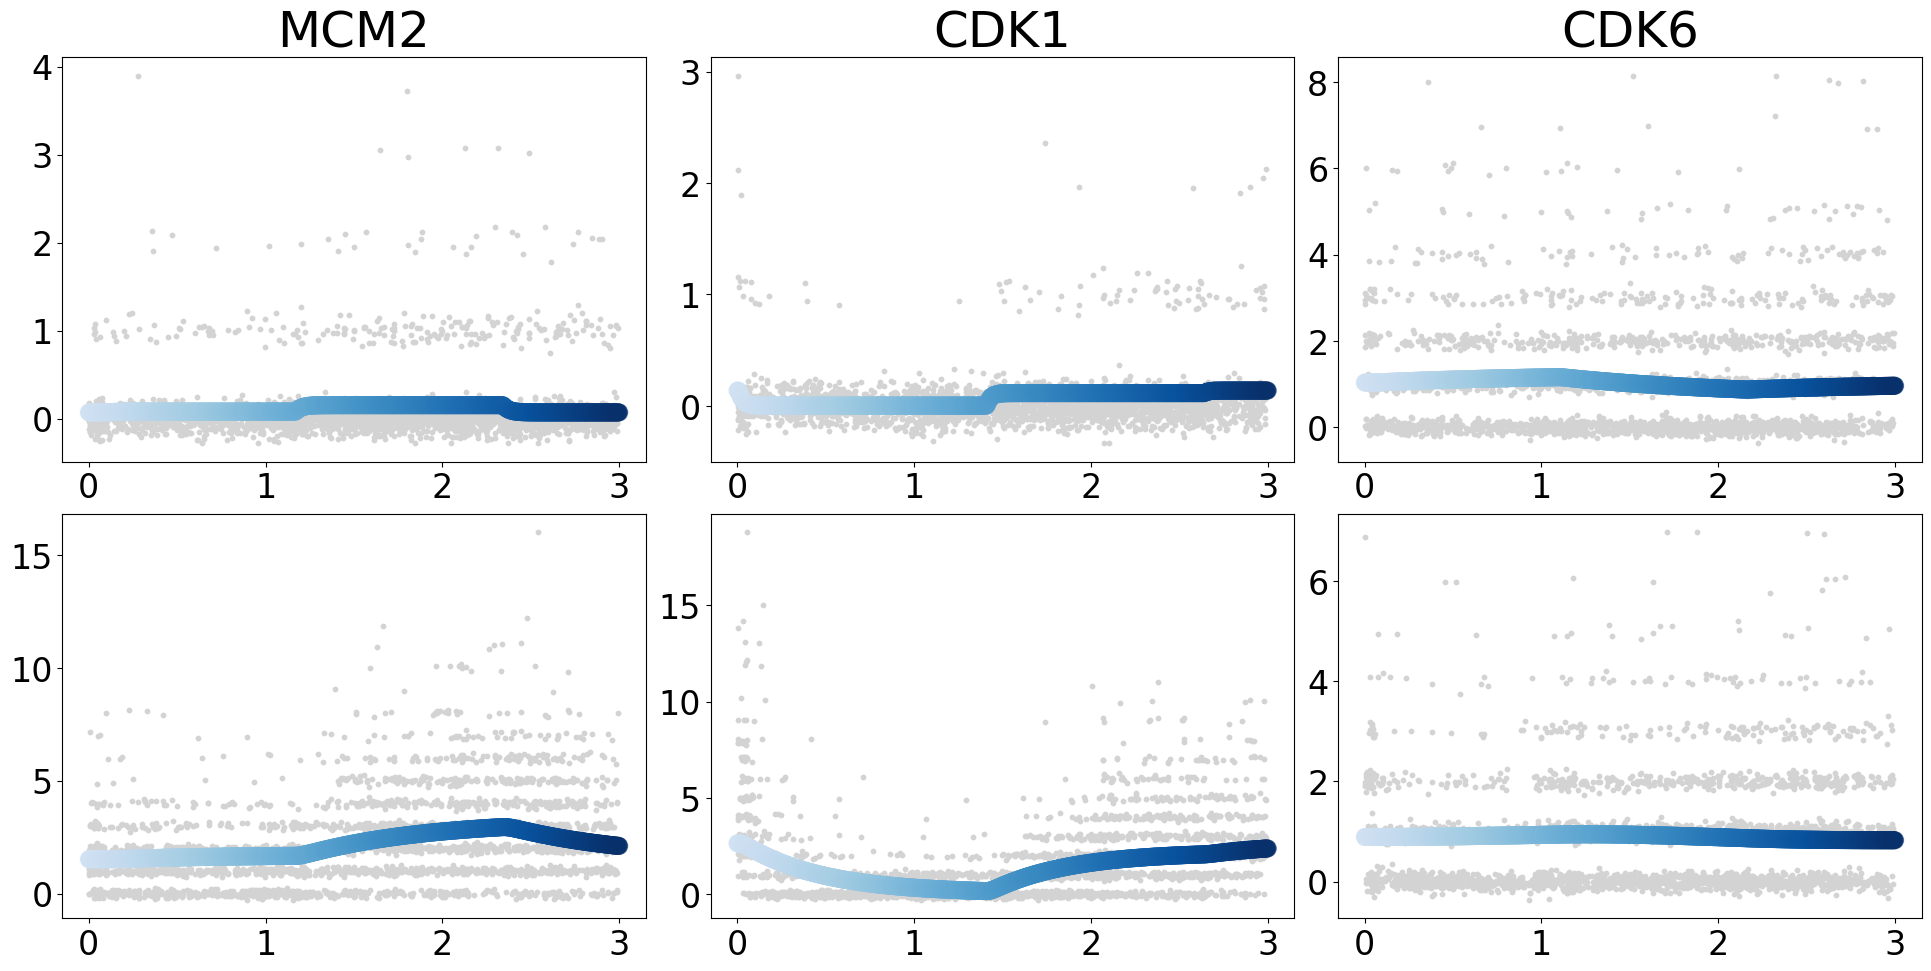

In [805]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

In [727]:
data.keys()

dict_keys(['PM', 'ws', 'ri', 'ri_tau', 'ri_tau_1', 'ri_tau_2'])

In [684]:
with open('results/RPE1.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

## Bootstrap

In [240]:
from sklearn.utils import resample

tau = (0,1,2,3)
topo = np.array([[0,1,2,0]])
n = len(X)

Input_args = []
def fit_wrapper(seed):
    bootstrap_idx = resample(np.arange(n),replace=True,n_samples=n,random_state=seed)
    X_b = X[bootstrap_idx]
    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj_b = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj_b = traj_b.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj_b)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [596]:
bins = 100
corrs = []
AICs = []
original_t = traj.Q.sum(1) @ traj.t

for bootstrap_idx,traj_b in bootstraps:
    ref_t = original_t[bootstrap_idx]
    t_hat = traj_b.Q.sum(1) @ traj_b.t
    corr = []
    for i in range(bins):
        shifted_t_hat = t_hat - i/bins * traj_b.tau[-1]
        shifted_t_hat[shifted_t_hat<0] += traj_b.tau[-1]
        corr.append(pearsonr(ref_t,shifted_t_hat)[0])
    corrs.append(np.max(corr))
    AICs.append( traj_b.compute_AIC(traj_b.X, standard=True) )

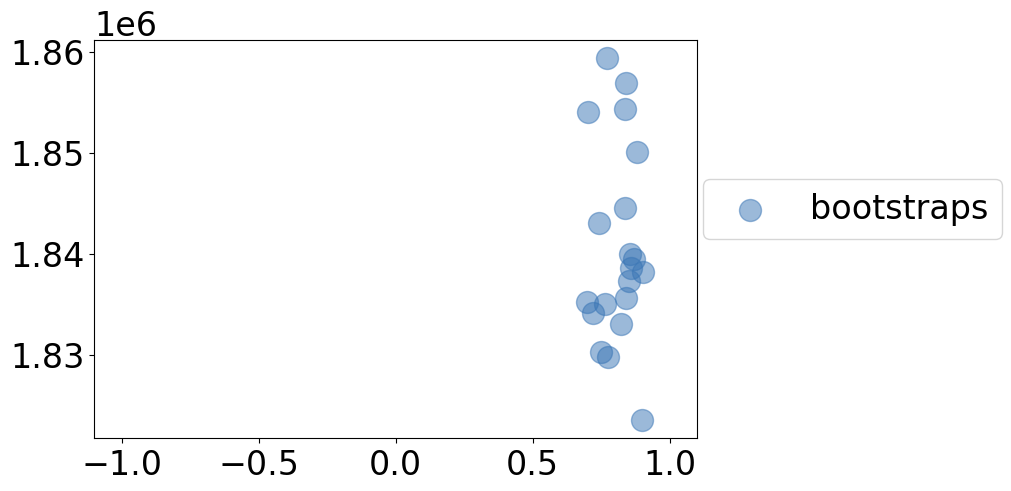

In [597]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='bootstraps')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

In [598]:
corrs

[0.9008194063188877,
 0.7194144880692679,
 0.7689682750029361,
 0.8415023012985294,
 0.7621249495582607,
 0.8360040868683268,
 0.8413295769708149,
 0.869289651677564,
 0.8991992303746473,
 0.820587060002346,
 0.8360191106216699,
 0.7031716882245855,
 0.8803425152507066,
 0.741712422634048,
 0.8507157115631956,
 0.8532609099592156,
 0.6983229925606167,
 0.7749823168294436,
 0.7478773237444601,
 0.8597764042610427]

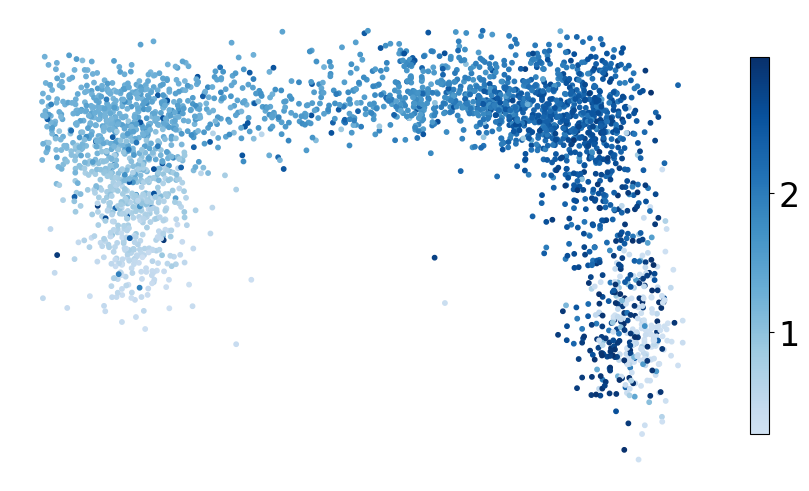

In [291]:
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
im=ax.scatter(xx[:,0],xx[:,1],c=traj.Q.sum(1)@traj.t,cmap=cmap_y,s=10);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink = 0.8) # adding the colobar on the right

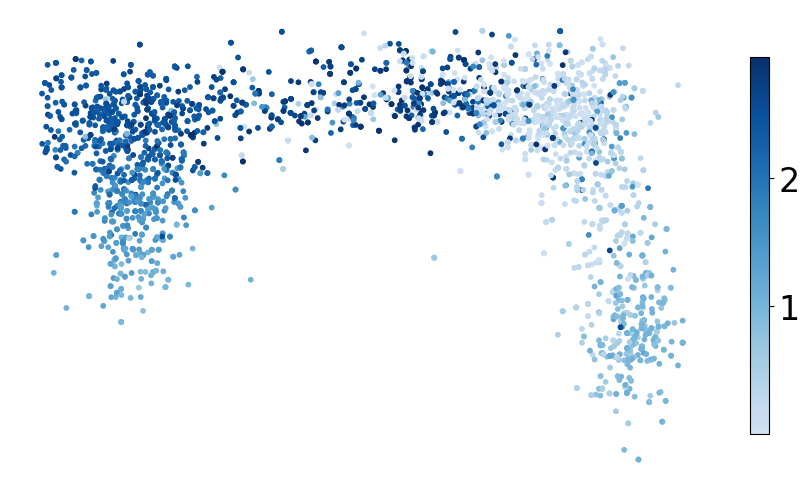

In [292]:
bootstrap_idx,traj_b = bootstraps[1]
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
im=ax.scatter(xx[bootstrap_idx,0],xx[bootstrap_idx,1],c=traj_b.Q.sum(1)@traj_b.t,cmap=cmap_y,s=10);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink = 0.8) # adding the colobar on the right

In [296]:
bootstrap_idx,traj_b = bootstraps[1]
t_hat = traj_b.Q.sum(1) @ traj_b.t
corr = []
for i in range(100):
    shifted_t_hat = t_hat - i/100 * traj_b.tau[-1]
    shifted_t_hat[shifted_t_hat<0] += traj_b.tau[-1]
    corr.append(pearsonr(original_t[bootstrap_idx],shifted_t_hat)[0])
np.argmax(corr)

27

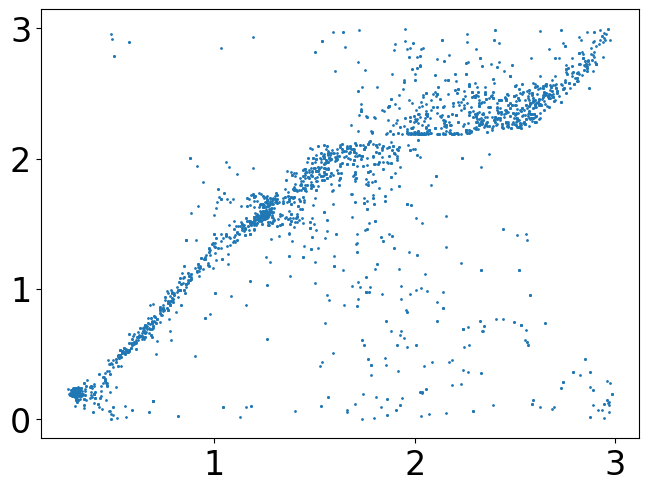

In [297]:
i = 27
shifted_t_hat = t_hat - i/100 * traj_b.tau[-1]
shifted_t_hat[shifted_t_hat<0] += traj_b.tau[-1]

plt.scatter(original_t[bootstrap_idx],shifted_t_hat,s=1)

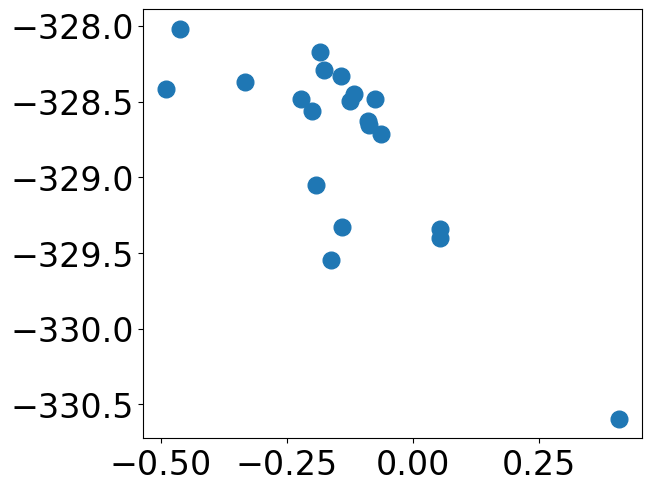

In [299]:
corrs = []
elbos = []

original_t = traj.Q.sum(1) @ traj.t
ref_t = original_t[bootstrap_idx]
for i in range(len(traj_b.elbos)):
    t_hat = traj_b.Qs[i].sum(1) @ traj_b.t
    corrs.append(pearsonr(ref_t,t_hat)[0])
    elbos.append( traj_b.elbos[i][-1] )
plt.scatter(corrs,elbos)

# Trajectory fitting on selected genes

In [300]:
p = len(gene_logL)
dlogL = gene_logL - cluster_gene_logL
dH = (cluster_KL-KL)/p
good_mask = (dlogL>dH) \
            & (traj.theta[:,-2]<500)  \
            & (traj.theta[:,-1]<100)
good_idx = np.arange(p)[good_mask]
X_good = X[:,good_idx]

print(good_mask.mean())
len(good_idx)

0.46153846153846156


84

In [301]:
from multiprocessing import Pool

tau = (0,1,2,3)
topo = np.array([[0,1,2,0]])

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_good,m=100,n_init=1,fit_tau=True,params={"r":rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj 
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs_good = pool.starmap(fit_wrapper, Input_args, chunksize=1)

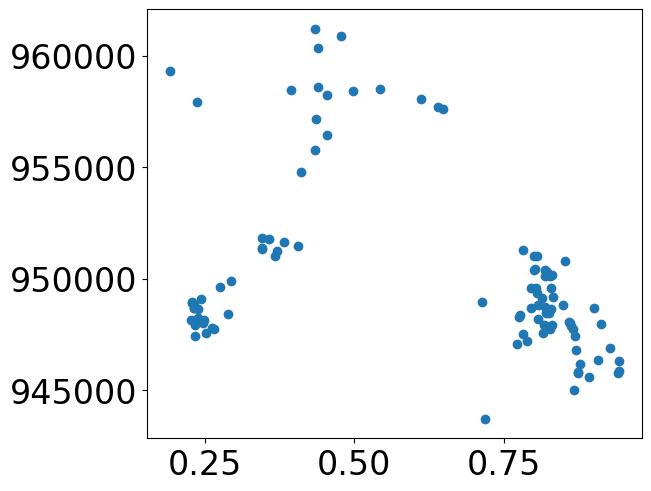

In [313]:
corrs = []
AICs = []
ref_t = traj.Q[:,0] @ traj.t
for traj_temp in trajs_good:
    t_hat = traj_temp.Q[:,0] @ traj_temp.t
    corr = []
    for i in range(100):
        shifted_t_hat = t_hat - i/100 * traj_temp.tau[-1]
        shifted_t_hat[shifted_t_hat<0] += 3
        corr.append(pearsonr(ref_t,shifted_t_hat)[0])
    corrs.append(np.max(corr))
    AICs.append( traj_temp.compute_AIC(traj_temp.X, standard=True) )
    
plt.plot(corrs,AICs,'.')

In [311]:
from sklearn.utils import resample

n = len(X_good)

Input_args = []
def fit_wrapper(seed):
    bootstrap_idx = resample(np.arange(n),replace=True,n_samples=n,random_state=seed)
    X_b = X_good[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj_b = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj_b = traj_b.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj_b)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    bootstraps_good = pool.starmap(fit_wrapper, Input_args, chunksize=1)

(-1.1, 1.1)

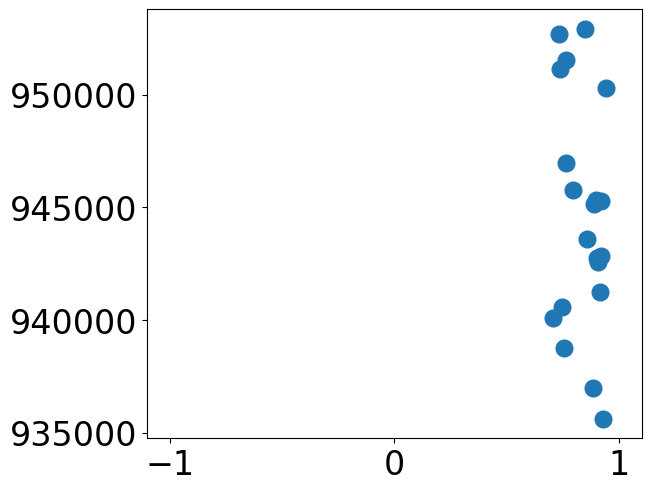

In [315]:
bins = 1000
corrs = []
AICs = []
original_t = traj.Q.sum(1) @ traj.t

for bootstrap_idx,traj_b in bootstraps_good:
    ref_t = original_t[bootstrap_idx]
    t_hat = traj_b.Q.sum(1) @ traj_b.t
    corr = []
    for i in range(bins):
        shifted_t_hat = t_hat - i/bins * traj_b.tau[-1]
        shifted_t_hat[shifted_t_hat<0] += traj_b.tau[-1]
        corr.append(pearsonr(ref_t,shifted_t_hat)[0])
    corrs.append(np.max(corr))
    AICs.append( traj_b.compute_AIC(traj_b.X, standard=True) )
    
fig, ax = plt.subplots(1,1)
ax.scatter(corrs,AICs)
ax.set_xlim([-1.1,1.1])